In [1]:
!pip install torch-fidelity

In [2]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from irt import IRT
import os
device ='cuda:0'

## Compute SDXL SD1.5 CMMD Embeddings

In [3]:
from diffusion_adapters import StableDiffusionXLPipelineAdapterEmbeddings
from diffusers.utils import load_image

pipe = StableDiffusionXLPipelineAdapterEmbeddings.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
).to("cuda")
pipe.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter_sdxl.bin")

C:\Users\Gabriel\.cache\huggingface\hub\models--stabilityai--stable-diffusion-xl-base-1.0\snapshots\462165984030d82259a11f4367a4eed129e94a7b


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [26]:
PR_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/test"

scores = dict.fromkeys(os.listdir(PR_DIR))

for candidate in os.listdir(PR_DIR):
    if candidate != "SPU_80_GS_7.5__NEG__usrthrs_100_exp":
        continue
    candidate_dir = os.path.join(PR_DIR, candidate)
    user_scores = dict.fromkeys(os.listdir(candidate_dir))
    for user in os.listdir(candidate_dir):
        
        images_dir = os.path.join(candidate_dir, user, "images")
        sdxl_ipadapter_embs = []
        with torch.no_grad():
            for path in os.listdir(images_dir):
                #path = "../data/raw/FLICKR-AES-001/40K/" + unq_img_path
                impath = os.path.join(images_dir, path)
                pil_image = load_image(impath)
                image_emb = pipe.encode_image(pil_image, device="cuda", num_images_per_prompt=1)[0].squeeze()
                sdxl_ipadapter_embs.append(image_emb.cpu())
            sdxl_ipadapter_embs_tensor = torch.stack(sdxl_ipadapter_embs)
            torch.save(sdxl_ipadapter_embs_tensor, f"{images_dir}/../embeddings/sdxl_embeddings.pth")

In [86]:
from diffusion_adapters import StableDiffusionXLPipelineAdapterEmbeddings, StableDiffusionPipelineAdapterEmbeddings
from diffusers.utils import load_image

model_id = "runwayml/stable-diffusion-v1-5"                                                                                                                                                                                                                
pipe = StableDiffusionPipelineAdapterEmbeddings.from_pretrained(model_id).to("cuda")
pipe.load_ip_adapter("h94/IP-Adapter", subfolder="models", weight_name="ip-adapter_sd15.bin")     
pipe.safety_checker = None # Prudes
device = "cuda"

C:\Users\Gabriel\.cache\huggingface\hub\models--runwayml--stable-diffusion-v1-5\snapshots\451f4fe16113bff5a5d2269ed5ad43b0592e9a14


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [88]:
PR_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/test"

scores = dict.fromkeys(os.listdir(PR_DIR))

for candidate in os.listdir(PR_DIR):
    print(f"Processing {candidate}...")
    candidate_dir = os.path.join(PR_DIR, candidate)
    user_scores = dict.fromkeys(os.listdir(candidate_dir))
    for user in os.listdir(candidate_dir):
        
        images_dir = os.path.join(candidate_dir, user, "images")
        sd15_ipadapter_embs = []
        with torch.no_grad():
            for path in os.listdir(images_dir):
                #path = "../data/raw/FLICKR-AES-001/40K/" + unq_img_path
                impath = os.path.join(images_dir, path)
                pil_image = load_image(impath)
                image_emb = pipe.encode_image(pil_image, device="cuda", num_images_per_prompt=1)[0].squeeze()
                sd15_ipadapter_embs.append(image_emb.cpu())
            sd15_ipadapter_embs_tensor = torch.stack(sd15_ipadapter_embs)
            torch.save(sd15_ipadapter_embs_tensor, f"{images_dir}/../embeddings/sd15_embeddings.pth")

Processing SPU_50_GS_3.5__NEG__usrthrs_100_exp...
Processing SPU_50_GS_5.5__NEG__usrthrs_100_exp...
Processing SPU_50_GS_7.5__NEG__usrthrs_100_exp...
Processing SPU_80_GS_10.0__NEG__usrthrs_100_exp...
Processing SPU_80_GS_12.0__NEG__usrthrs_100_exp...
Processing SPU_80_GS_14.0__NEG__usrthrs_100_exp...
Processing SPU_80_GS_16.0__NEG__usrthrs_100_exp...
Processing SPU_80_GS_18.0__NEG__usrthrs_100_exp...
Processing SPU_80_GS_20.0__NEG__usrthrs_100_exp...
Processing SPU_80_GS_3.5__NEG__usrthrs_100_exp...
Processing SPU_80_GS_5.5__NEG__usrthrs_100_exp...
Processing SPU_80_GS_7.5__NEG__usrthrs_100_exp...
Processing SPU_80_GS_8.0__NEG__usrthrs_100_exp...


In [51]:
PR_DIR = "../data/flickr/evaluation/baselines/t2_prompt"

images_dir = f"{PR_DIR}/images"
sd15_ipadapter_embs = []
with torch.no_grad():
    for path in os.listdir(images_dir):
        #path = "../data/raw/FLICKR-AES-001/40K/" + unq_img_path
        impath = images_dir + "/" + path
        pil_image = load_image(impath)
        image_emb = pipe.encode_image(pil_image, device="cuda", num_images_per_prompt=1)[0].squeeze()
        sd15_ipadapter_embs.append(image_emb.cpu())
    sd15_ipadapter_embs_tensor = torch.stack(sd15_ipadapter_embs)
    torch.save(sd15_ipadapter_embs_tensor, f"{PR_DIR}/embeddings/sd15_embeddings.pth")

In [95]:
from eval_utils import compute_embeddings_for_dir, ClipEmbeddingModel
GT_IMAGES_DIR = "../data/flickr/evaluation/ground_truth/usrthrs_100/liked/images"

embedding_model = ClipEmbeddingModel()
embeds = compute_embeddings_for_dir(GT_IMAGES_DIR, embedding_model, batch_size=32, max_count=-1)
torch.save(embeds, f"{GT_IMAGES_DIR}/../embeddings/cmmd_embeddings.pth")

Calculating embeddings for 351 images from ../data/flickr/evaluation/ground_truth/usrthrs_100/liked/images.


100%|██████████| 11/11 [01:56<00:00, 10.59s/it]


In [2]:
from eval_utils import compute_embeddings_for_dir, ClipEmbeddingModel
REBECA_T2_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1"
embedding_model = ClipEmbeddingModel()

for upath in os.listdir(REBECA_T2_DIR):
    print(upath)
    embeds = compute_embeddings_for_dir(f"{REBECA_T2_DIR}/{upath}/images", embedding_model, batch_size=32, max_count=-1)
    torch.save(embeds, f"{REBECA_T2_DIR}/{upath}/embeddings/cmmd_embeddings.pth")

user_0
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_0/images.


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


user_1
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_1/images.


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


user_10
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_10/images.


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


user_11
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_11/images.


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


user_12
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_12/images.


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


user_13
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_13/images.


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


user_14
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_14/images.


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


user_15
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_15/images.


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


user_16
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_16/images.


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


user_17
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_17/images.


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


user_18
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_18/images.


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


user_19
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_19/images.


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


user_2
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_2/images.


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


user_20
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_20/images.


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


user_21
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_21/images.


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


user_22
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_22/images.


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


user_23
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_23/images.


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


user_24
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_24/images.


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


user_25
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_25/images.


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


user_26
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_26/images.


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


user_27
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_27/images.


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


user_28
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_28/images.


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


user_29
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_29/images.


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


user_3
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_3/images.


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


user_30
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_30/images.


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


user_31
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_31/images.


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


user_32
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_32/images.


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


user_33
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_33/images.


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


user_34
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_34/images.


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


user_35
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_35/images.


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


user_36
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_36/images.


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


user_37
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_37/images.


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


user_38
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_38/images.


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


user_39
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_39/images.


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


user_4
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_4/images.


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


user_40
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_40/images.


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


user_41
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_41/images.


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


user_42
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_42/images.


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


user_43
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_43/images.


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


user_44
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_44/images.


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


user_45
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_45/images.


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


user_46
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_46/images.


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


user_47
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_47/images.


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


user_48
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_48/images.


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


user_49
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_49/images.


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


user_5
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_5/images.


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


user_50
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_50/images.


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


user_51
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_51/images.


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


user_52
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_52/images.


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


user_53
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_53/images.


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


user_54
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_54/images.


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


user_55
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_55/images.


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


user_56
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_56/images.


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


user_57
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_57/images.


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


user_58
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_58/images.


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


user_59
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_59/images.


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


user_6
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_6/images.


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


user_60
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_60/images.


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


user_61
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_61/images.


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


user_62
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_62/images.


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


user_63
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_63/images.


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


user_64
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_64/images.


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


user_65
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_65/images.


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


user_66
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_66/images.


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


user_67
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_67/images.


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


user_68
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_68/images.


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


user_69
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_69/images.


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


user_7
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_7/images.


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


user_70
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_70/images.


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


user_71
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_71/images.


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


user_72
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_72/images.


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


user_73
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_73/images.


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


user_74
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_74/images.


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


user_75
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_75/images.


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


user_76
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_76/images.


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


user_77
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_77/images.


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


user_78
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_78/images.


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


user_79
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_79/images.


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


user_8
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_8/images.


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


user_80
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_80/images.


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


user_81
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_81/images.


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


user_82
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_82/images.


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


user_83
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_83/images.


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


user_84
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_84/images.


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


user_85
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_85/images.


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


user_86
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_86/images.


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


user_87
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_87/images.


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


user_88
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_88/images.


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


user_89
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_89/images.


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


user_9
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_9/images.


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


user_90
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_90/images.


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


user_91
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_91/images.


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


user_92
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_92/images.


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


user_93
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_93/images.


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


user_94
Calculating embeddings for 20 images from ../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1/user_94/images.


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


## IRT Classifier Scores

### Old IRT Model

In [7]:
BASELINE_T0_DIR = "../data/flickr/evaluation/baselines/t0_prompt/embeddings/sdxl_embeddings.pth"
BASELINE_T1_DIR = "../data/flickr/evaluation/baselines/t1_prompt/embeddings/sdxl_embeddings.pth"
BASELINE_T2_DIR = "../data/flickr/evaluation/baselines/t2_prompt/embeddings/sdxl_embeddings.pth"
REBECA_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_7.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti"
REBECA_DIR_T1 = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_7.0_high_quality_photo_NEG_bad_quality_photo,_letters"
REBECA_DIR_T0 = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_7.0__NEG_"
REBECA_DIR_T0_NOUe = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_7.0__NEG__useUE_False"
REBECA_DIR_T0_TEST = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_50_GS_7.0__NEG__usrthres_100"
IRT_MODELS_PATH = "../data/flickr/evaluation/irt_models/irt_model_interaction_v2"
IRT_MODELS_NOINT_PATH = "../data/flickr/evaluation/irt_models/irt_model_no-interaction_v2"
USER_IDS = list(range(188))

irt_model = IRT(interaction=True)
irt_model.load(IRT_MODELS_PATH)

irt_model_noint = IRT(interaction=False)
irt_model_noint.load(IRT_MODELS_NOINT_PATH)

In [8]:
baseline_t0_embeds = torch.load(BASELINE_T0_DIR, weights_only=True).to(torch.float32)
baseline_t0_scores = dict.fromkeys(USER_IDS)

for user in USER_IDS:
    sampled_rows = np.random.choice(baseline_t0_embeds.shape[0], size=50, replace=False)
    sampled_image_embeds = baseline_t0_embeds[sampled_rows]
    user_id_tokens = (user * torch.ones(50)).to(torch.int64)
    baseline_t0_scores[user] = irt_model.score(user_id_tokens, sampled_image_embeds)[user]

t0_averages = [score['avg'] for score in baseline_t0_scores.values()]
t0_std_errors = [score['std_error'] for score in baseline_t0_scores.values()]

In [9]:
baseline_t1_embeds = torch.load(BASELINE_T1_DIR, weights_only=True).to(torch.float32)
baseline_t1_scores = dict.fromkeys(USER_IDS)

for user in USER_IDS:
    sampled_rows = np.random.choice(baseline_t1_embeds.shape[0], size=20, replace=False)
    sampled_image_embeds = baseline_t1_embeds[sampled_rows]
    user_id_tokens = (user * torch.ones(20)).to(torch.int64)
    baseline_t1_scores[user] = irt_model.score(user_id_tokens, sampled_image_embeds)[user]

t1_averages = [score['avg'] for score in baseline_t1_scores.values()]
t1_std_errors = [score['std_error'] for score in baseline_t1_scores.values()]

In [10]:
baseline_t2_embeds = torch.load(BASELINE_T2_DIR, weights_only=True).to(torch.float32)
baseline_t2_scores = dict.fromkeys(USER_IDS)

for user in USER_IDS:
    sampled_rows = np.random.choice(baseline_t2_embeds.shape[0], size=50, replace=False)
    sampled_image_embeds = baseline_t2_embeds[sampled_rows]
    user_id_tokens = (user * torch.ones(50)).to(torch.int64)
    baseline_t2_scores[user] = irt_model.score(user_id_tokens, sampled_image_embeds)[user]

t2_averages = [score['avg'] for score in baseline_t2_scores.values()]
t2_std_errors = [score['std_error'] for score in baseline_t2_scores.values()]

In [11]:
rebeca_scores = dict.fromkeys(USER_IDS)
rebeca_noint_scores = dict.fromkeys(USER_IDS)

for user in USER_IDS:
    user_embed_path = f"{REBECA_DIR}/user_{user}/embeddings/sdxl_embeddings.pth"
    user_embeds = torch.load(user_embed_path, weights_only=True).to(torch.float32)
    user_id_tokens = (user * torch.ones(50)).to(torch.int64)
    rebeca_scores[user] = irt_model.score(user_id_tokens, user_embeds)[user]
    rebeca_noint_scores[user] = irt_model_noint.score(user_id_tokens, user_embeds)[user]

rebeca_averages = [score['avg'] for score in rebeca_scores.values()]
rebeca_std_errors = [score['std_error'] for score in rebeca_scores.values()]

rebeca_noint_averages = [score['avg'] for score in rebeca_noint_scores.values()]
rebeca_noint_std_errors = [score['std_error'] for score in rebeca_noint_scores.values()]

In [12]:
rebeca_t1_scores = dict.fromkeys(USER_IDS)
rebeca_t1_noint_scores = dict.fromkeys(USER_IDS)

for user in USER_IDS:
    user_embed_path = f"{REBECA_DIR_T1}/user_{user}/embeddings/sdxl_embeddings.pth"
    user_embeds = torch.load(user_embed_path, weights_only=True).to(torch.float32)
    user_id_tokens = (user * torch.ones(20)).to(torch.int64)
    rebeca_t1_scores[user] = irt_model.score(user_id_tokens, user_embeds)[user]
    rebeca_t1_noint_scores[user] = irt_model_noint.score(user_id_tokens, user_embeds)[user]

rebeca_t1_averages = [score['avg'] for score in rebeca_t1_scores.values()]
rebeca_t1_std_errors = [score['std_error'] for score in rebeca_t1_scores.values()]

rebeca_t1_noint_averages = [score['avg'] for score in rebeca_t1_noint_scores.values()]
rebeca_t1_noint_std_errors = [score['std_error'] for score in rebeca_t1_noint_scores.values()]

In [13]:
rebeca_t0_scores = dict()
rebeca_t0_noint_scores = dict()

for upath in os.listdir(REBECA_DIR_T0):
    user = int(upath.split("_")[1])
    user_embed_path = f"{REBECA_DIR_T0}/user_{user}/embeddings/sdxl_embeddings.pth"
    user_embeds = torch.load(user_embed_path, weights_only=True).to(torch.float32)
    user_id_tokens = (user * torch.ones(30)).to(torch.int64)
    rebeca_t0_scores[user] = irt_model.score(user_id_tokens, user_embeds)[user]
    rebeca_t0_noint_scores[user] = irt_model_noint.score(user_id_tokens, user_embeds)[user]

rebeca_t0_averages = [score['avg'] for score in rebeca_t0_scores.values()]
rebeca_t0_std_errors = [score['std_error'] for score in rebeca_t0_scores.values()]

rebeca_t0_noint_averages = [score['avg'] for score in rebeca_t0_noint_scores.values()]
rebeca_t0_noint_std_errors = [score['std_error'] for score in rebeca_t0_noint_scores.values()]

In [101]:
rebeca_t0_noue_scores = dict()
rebeca_t0_noint_noue_scores = dict()

for upath in os.listdir(REBECA_DIR_T0_NOUe):
    user = int(upath.split("_")[1])
    user_embed_path = f"{REBECA_DIR_T0_NOUe}/user_{user}/embeddings/sdxl_embeddings.pth"
    user_embeds = torch.load(user_embed_path, weights_only=True).to(torch.float32)
    user_id_tokens = (user * torch.ones(30)).to(torch.int64)
    rebeca_t0_noue_scores[user] = irt_model.score(user_id_tokens, user_embeds)[user]
    rebeca_t0_noint_noue_scores[user] = irt_model_noint.score(user_id_tokens, user_embeds)[user]

rebeca_t0_noue_averages = [score['avg'] for score in rebeca_t0_noue_scores.values()]
rebeca_t0_noue_std_errors = [score['std_error'] for score in rebeca_t0_noue_scores.values()]

rebeca_t0_noint_noue_averages = [score['avg'] for score in rebeca_t0_noint_noue_scores.values()]
rebeca_t0_noint_noue_std_errors = [score['std_error'] for score in rebeca_t0_noint_noue_scores.values()]

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_28624\2475985553.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bxplt.set_xticklabels(["T0", "REBECA_T0", "REBECA_T0_NOUE"])


[Text(0, 0, 'T0'), Text(1, 0, 'REBECA_T0'), Text(2, 0, 'REBECA_T0_NOUE')]

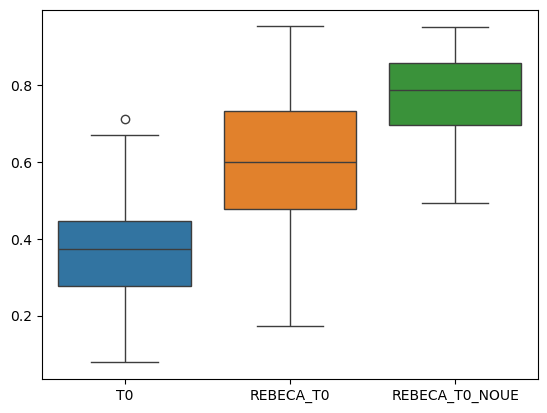

In [102]:
bxplt = sns.boxplot(
    data=[t0_averages, rebeca_t0_averages,   rebeca_t0_noue_averages],
)

bxplt.set_xticklabels(["T0", "REBECA_T0", "REBECA_T0_NOUE"])

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_28624\1326759416.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bxplt.set_xticklabels(["T0", "REBECA_T0", "REBECA_T0_NOINT", "T1", "REBECA_T1", "REBECA_T1_NOINT", "T2", "REBECA", "REBECA_NOINT"])


[Text(0, 0, 'T0'),
 Text(1, 0, 'REBECA_T0'),
 Text(2, 0, 'REBECA_T0_NOINT'),
 Text(3, 0, 'T1'),
 Text(4, 0, 'REBECA_T1'),
 Text(5, 0, 'REBECA_T1_NOINT'),
 Text(6, 0, 'T2'),
 Text(7, 0, 'REBECA'),
 Text(8, 0, 'REBECA_NOINT')]

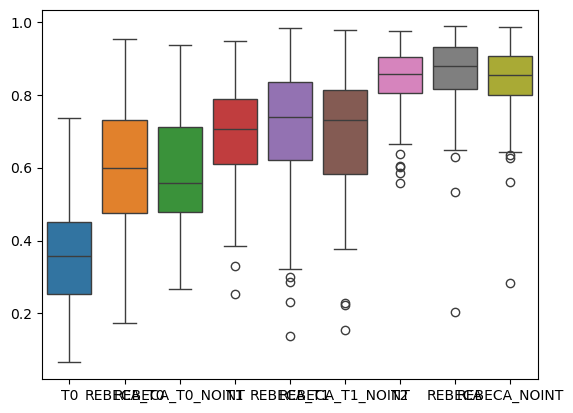

In [89]:
bxplt = sns.boxplot(
    data=[t0_averages, rebeca_t0_averages, rebeca_t0_noint_averages,  t1_averages, rebeca_t1_averages, rebeca_t1_noint_averages, t2_averages, rebeca_averages, rebeca_noint_averages],
)

bxplt.set_xticklabels(["T0", "REBECA_T0", "REBECA_T0_NOINT", "T1", "REBECA_T1", "REBECA_T1_NOINT", "T2", "REBECA", "REBECA_NOINT"])

C:\Users\hohlx\AppData\Local\Temp\ipykernel_17200\1000427988.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bxplt.set_xticklabels(["T0", "T1", "T2", "REBECA"])


[Text(0, 0, 'T0'), Text(1, 0, 'T1'), Text(2, 0, 'T2'), Text(3, 0, 'REBECA')]

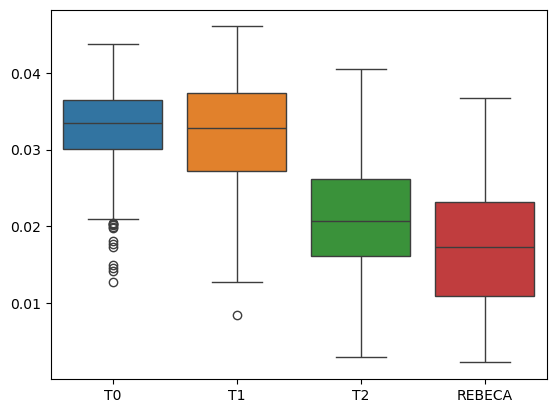

In [10]:
bxplt = sns.boxplot(
    data=[t0_std_errors, t1_std_errors, t2_std_errors, rebeca_std_errors],
)

bxplt.set_xticklabels(["T0", "T1", "T2", "REBECA"])

### User-by-User Stuff

In [10]:
import matplotlib.pyplot as plt

In [11]:
user_id  = 7
user_embed_path = f"{REBECA_DIR_T1}/user_{user_id}/embeddings/sdxl_embeddings.pth"
user_embeds = torch.load(user_embed_path, weights_only=True).to(torch.float32)
perm_user_scores = dict.fromkeys(USER_IDS)
for user in USER_IDS:
    #user_embed_path = f"{REBECA_DIR_T1}/user_{user}/embeddings/sdxl_embeddings.pth"
    user_id_tokens = (user * torch.ones(20)).to(torch.int64)
    perm_user_scores[user] = irt_model.score(user_id_tokens, user_embeds)[user]

#rebeca_t1_averages = [score['avg'] for score in rebeca_t1_scores.values()]
#rebeca_t1_std_errors = [score['std_error'] for score in rebeca_t1_scores.values()]

NameError: name 'REBECA_DIR_T1' is not defined

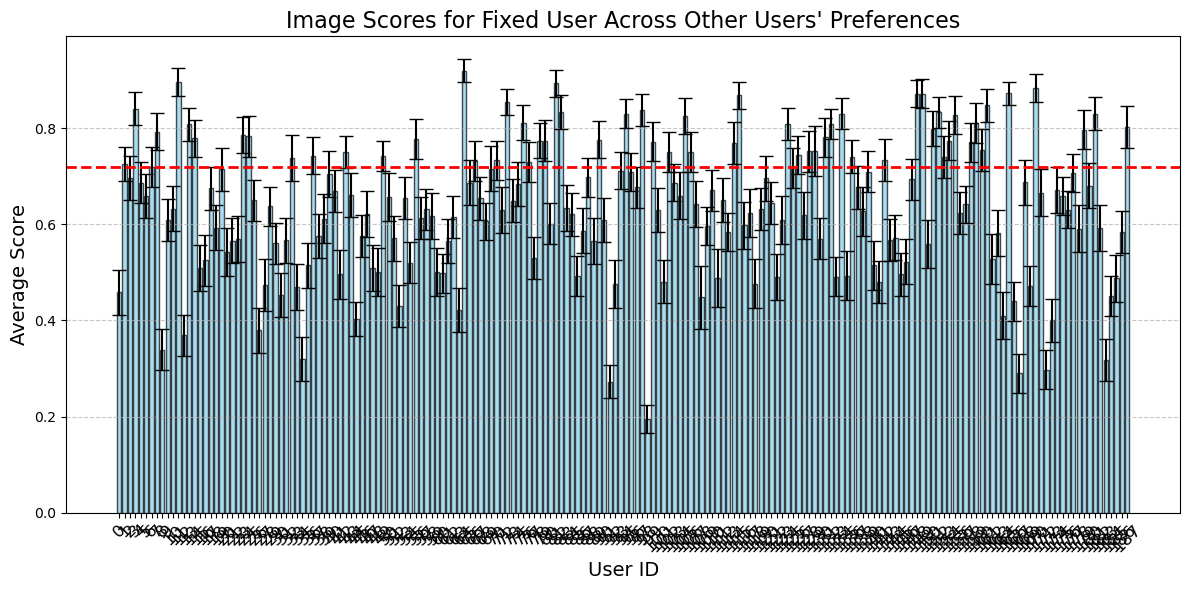

In [51]:
user_ids = list(perm_user_scores.keys())
avg_scores = [perm_user_scores[user]['avg'] for user in user_ids]
std_errors = [perm_user_scores[user]['std_error'] for user in user_ids]


true_user_avg = perm_user_scores[user_id]["avg"]
# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(user_ids, avg_scores, yerr=std_errors, capsize=5, alpha=0.7, color='skyblue', edgecolor='black')
plt.axhline(y=true_user_avg, color='red', linestyle='--', linewidth=2, label=f'True User Avg: {true_user_avg:.2f}')

# Customize the plot
plt.xlabel("User ID", fontsize=14)
plt.ylabel("Average Score", fontsize=14)
plt.title("Image Scores for Fixed User Across Other Users' Preferences", fontsize=16)
plt.xticks(user_ids, fontsize=12, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [58]:
heatmap_data = {}

for fixed_user_id in USER_IDS:
    user_embed_path = f"{REBECA_DIR}/user_{fixed_user_id}/embeddings/sdxl_embeddings.pth"
    user_embeds = torch.load(user_embed_path, weights_only=True).to(torch.float32)
    perm_user_scores = {}
    
    for user in USER_IDS:
        user_id_tokens = (user * torch.ones(50)).to(torch.int64)
        score_dict = irt_model.score(user_id_tokens, user_embeds)[user]
        perm_user_scores[user] = score_dict['avg']
    
    heatmap_data[fixed_user_id] = perm_user_scores

heatmap_df = pd.DataFrame.from_dict(heatmap_data, orient='index', columns=USER_IDS)

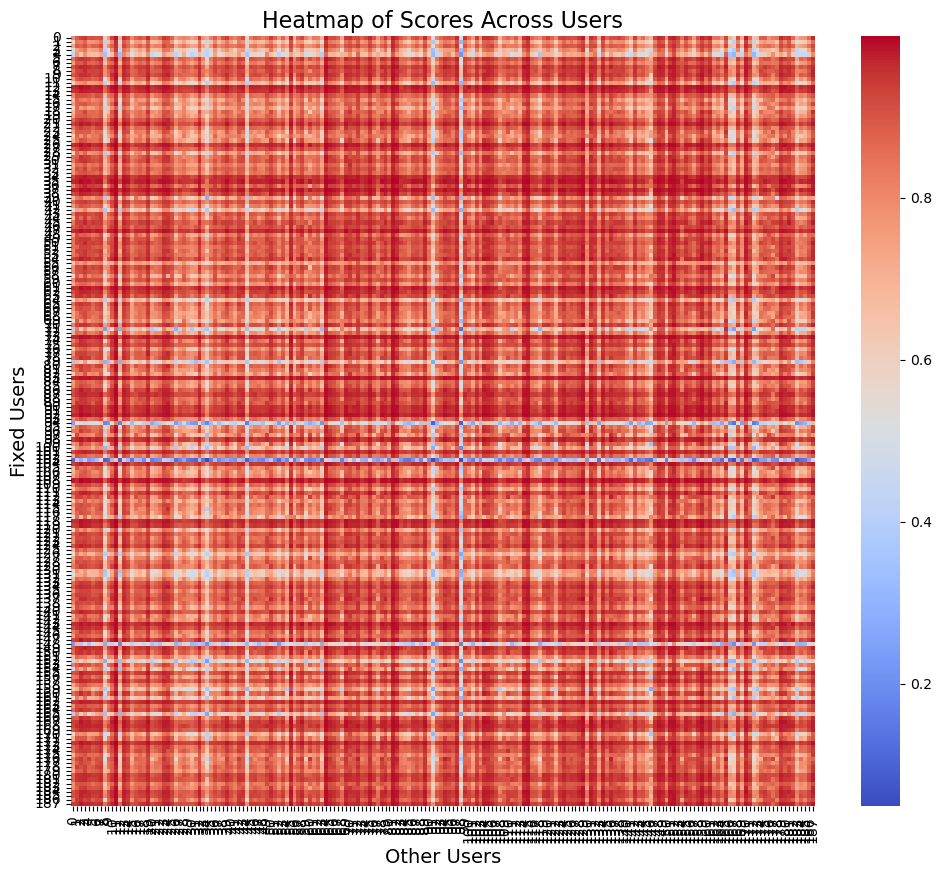

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_df, annot=False, cmap="coolwarm", cbar=True, xticklabels=True, yticklabels=True)
plt.title("Heatmap of Scores Across Users", fontsize=16)
plt.xlabel("Other Users", fontsize=14)
plt.ylabel("Fixed Users", fontsize=14)
plt.show()

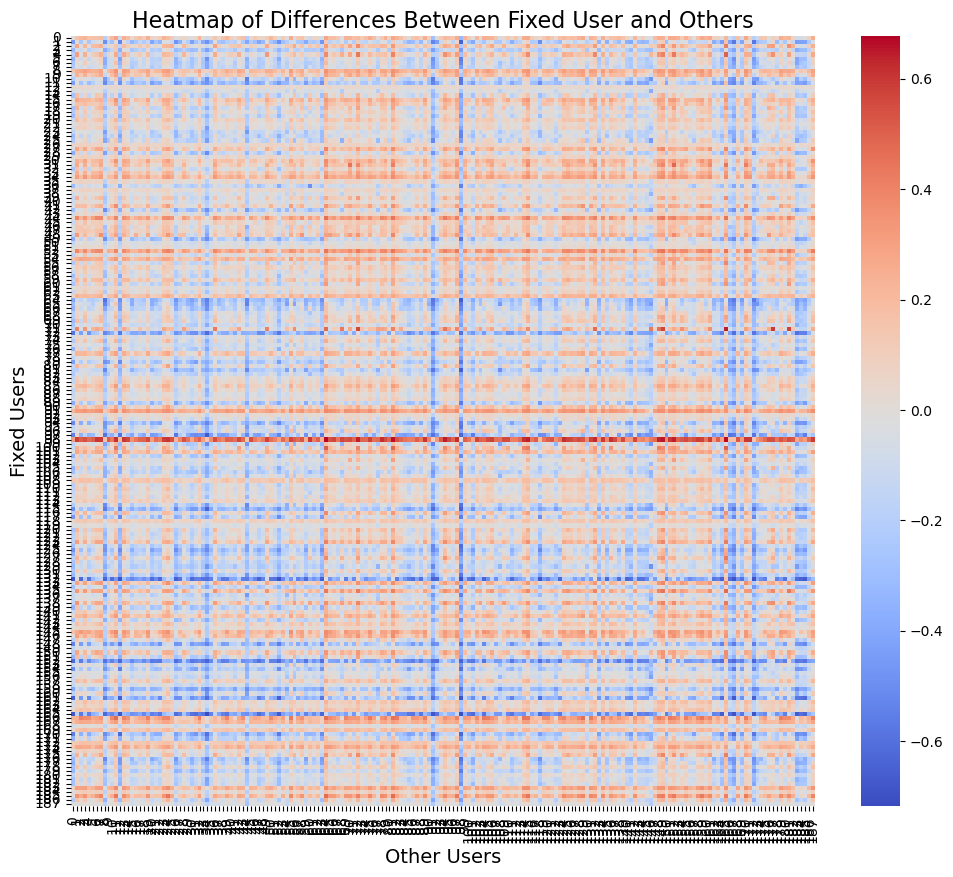

In [60]:
heatmap_diff_data = {}
for fixed_user_id in USER_IDS:
    user_embed_path = f"{REBECA_DIR_T1}/user_{fixed_user_id}/embeddings/sdxl_embeddings.pth"
    user_embeds = torch.load(user_embed_path, weights_only=True).to(torch.float32)
    perm_user_scores = {}
    
    # Calculate scores for all users
    for user in USER_IDS:
        user_id_tokens = (user * torch.ones(20)).to(torch.int64)
        score_dict = irt_model.score(user_id_tokens, user_embeds)[user]
        perm_user_scores[user] = score_dict['avg']  # Extract only 'avg' values
    
    # Calculate the differences: fixed user scores - scores of others
    fixed_user_score = perm_user_scores[fixed_user_id]  # Score of the fixed user
    perm_user_differences = {user: perm_user_scores[user] - fixed_user_score for user in USER_IDS}
    
    # Store the differences as a row in the heatmap data
    heatmap_diff_data[fixed_user_id] = perm_user_differences

# Convert the heatmap data to a DataFrame
heatmap_diff_df = pd.DataFrame.from_dict(heatmap_diff_data, orient='index', columns=USER_IDS)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_diff_df,
    annot=False,  # Set True if you want to see the numerical differences
    cmap="coolwarm",
    cbar=True,
    xticklabels=True,
    yticklabels=True
)
plt.title("Heatmap of Differences Between Fixed User and Others", fontsize=16)
plt.xlabel("Other Users", fontsize=14)
plt.ylabel("Fixed Users", fontsize=14)
plt.show()

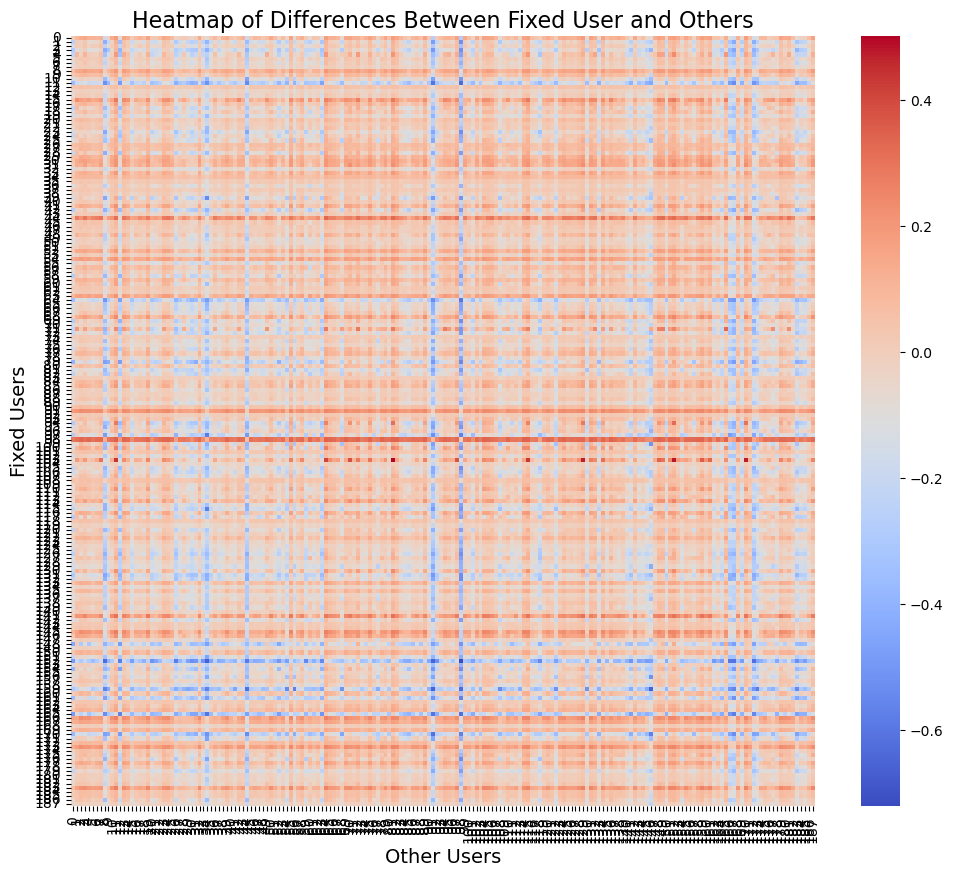

In [62]:
heatmap_diff_data = {}
for fixed_user_id in USER_IDS:
    user_embed_path = f"{REBECA_DIR}/user_{fixed_user_id}/embeddings/sdxl_embeddings.pth"
    user_embeds = torch.load(user_embed_path, weights_only=True).to(torch.float32)
    perm_user_scores = {}
    
    # Calculate scores for all users
    for user in USER_IDS:
        user_id_tokens = (user * torch.ones(50)).to(torch.int64)
        score_dict = irt_model.score(user_id_tokens, user_embeds)[user]
        perm_user_scores[user] = score_dict['avg']  # Extract only 'avg' values
    
    # Calculate the differences: fixed user scores - scores of others
    fixed_user_score = perm_user_scores[fixed_user_id]  # Score of the fixed user
    perm_user_differences = {user: perm_user_scores[user] - fixed_user_score for user in USER_IDS}
    
    # Store the differences as a row in the heatmap data
    heatmap_diff_data[fixed_user_id] = perm_user_differences

# Convert the heatmap data to a DataFrame
heatmap_diff_df = pd.DataFrame.from_dict(heatmap_diff_data, orient='index', columns=USER_IDS)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_diff_df,
    annot=False,  # Set True if you want to see the numerical differences
    cmap="coolwarm",
    cbar=True,
    xticklabels=True,
    yticklabels=True
)
plt.title("Heatmap of Differences Between Fixed User and Others", fontsize=16)
plt.xlabel("Other Users", fontsize=14)
plt.ylabel("Fixed Users", fontsize=14)
plt.show()

In [13]:
BASELINE_T0_DIR = "../data/flickr/evaluation/baselines/t0_prompt/embeddings/sdxl_embeddings.pth"
BASELINE_T1_DIR = "../data/flickr/evaluation/baselines/t1_prompt/embeddings/sdxl_embeddings.pth"
BASELINE_T2_DIR = "../data/flickr/evaluation/baselines/t2_prompt/embeddings/sdxl_embeddings.pth"
REBECA_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_7.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti"
REBECA_DIR_T1 = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_7.0_high_quality_photo_NEG_bad_quality_photo,_letters"
REBECA_DIR_T0 = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_7.0__NEG_"
REBECA_DIR_T0_NOUE = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_7.0__NEG__useUE_False"
IRT_MODELS_PATH = "../data/flickr/evaluation/irt_models/irt_model_interaction_v2"
IRT_MODELS_NOINT_PATH = "../data/flickr/evaluation/irt_models/irt_model_no-interaction_v2"
USER_IDS = list(range(188))

irt_model = IRT(interaction=True)
irt_model.load(IRT_MODELS_PATH)

irt_model_noint = IRT(interaction=False)irt_model_noint.load(IRT_MODELS_NOINT_PATH)

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_31260\2979460137.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bxplt.set_xticklabels(["IRT", "IRT_NOINT"])
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_31260\2979460137.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bxplt.set_xticklabels(["IRT", "IRT_NOINT"])
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_31260\2979460137.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bxplt.set_xticklabels(["IRT", "IRT_NOINT"])
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_31260\2979460137.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bxplt.set_xticklabels(["IRT", "IRT_NOINT"])


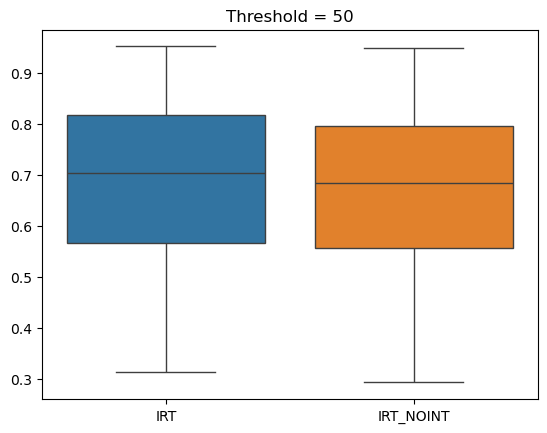

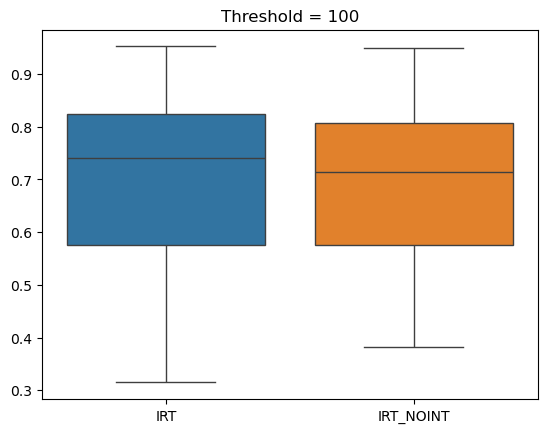

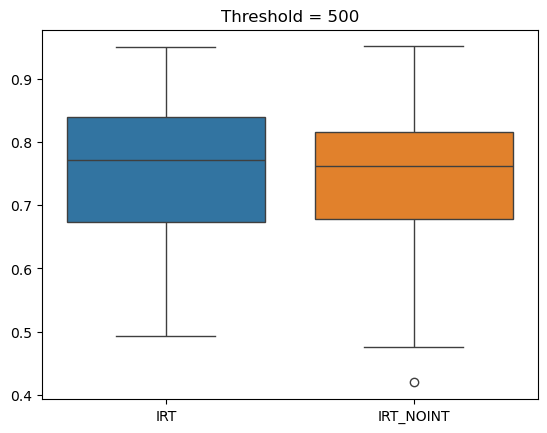

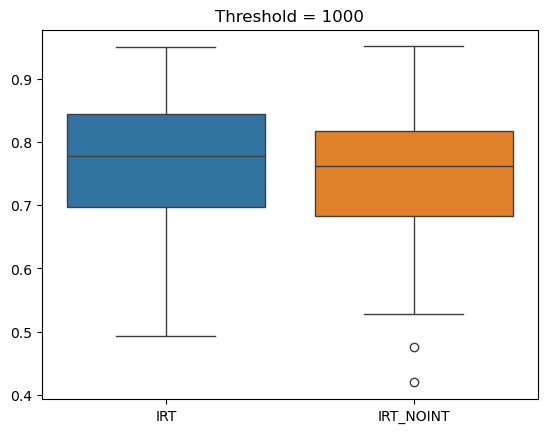

In [37]:
import matplotlib.pyplot as plt
user_liked_counts = pd.read_csv("../data/flickr/processed/user_liked_count.csv")
THRESHOLDS = [50, 100, 500, 1000]

SAMPLED_USER_IDS = []
for upath in os.listdir(REBECA_DIR_T0_NOUE):
    user_id = int(upath.split("_")[1])
    SAMPLED_USER_IDS.append(user_id)

for i, threshold in enumerate(THRESHOLDS):

    rebeca_noue_scores = dict.fromkeys(SAMPLED_USER_IDS)
    rebeca_noue_noint_scores = dict.fromkeys(SAMPLED_USER_IDS)

    for user_id in SAMPLED_USER_IDS:
        current_liked_count = user_liked_counts.loc[user_liked_counts['worker_id'] == user_id]['liked_count'][user_id]
        if current_liked_count < threshold:
            #print(f"User {user_id} is under threshold!")
            user_embed_path = f"{REBECA_DIR_T0_NOUE}/user_{user_id}/embeddings/sdxl_embeddings.pth"
            user_embeds = torch.load(user_embed_path, weights_only=True).to(torch.float32)
            sampled_rows = np.random.choice(user_embeds.shape[0], size=30, replace=False)
            sampled_user_embeds = user_embeds[sampled_rows]
            user_tokens = (user_id * torch.ones(30)).to(torch.int64)
            rebeca_noue_scores[user_id] = irt_model.score(user_tokens, sampled_user_embeds)[user_id]
            rebeca_noue_noint_scores[user_id] = irt_model_noint.score(user_tokens, sampled_user_embeds)[user_id]
        else:
            #print(f"User {user_id} is over threshold!")
            user_embed_path = f"{REBECA_DIR_T0}/user_{user_id}/embeddings/sdxl_embeddings.pth"
            user_embeds = torch.load(user_embed_path, weights_only=True).to(torch.float32)
            sampled_rows = np.random.choice(user_embeds.shape[0], size=30, replace=False)
            sampled_user_embeds = user_embeds[sampled_rows]
            user_tokens = (user_id * torch.ones(30)).to(torch.int64)
            rebeca_noue_scores[user_id] = irt_model.score(user_tokens, sampled_user_embeds)[user_id]
            rebeca_noue_noint_scores[user_id] = irt_model_noint.score(user_tokens, sampled_user_embeds)[user_id]

    #print(rebeca_noue_scores)
    #print(rebeca_noue_noint_scores)
    rebeca_noue_averages = [score['avg'] for score in rebeca_noue_scores.values()]
    rebeca_noue_noint_averages = [score['avg'] for score in rebeca_noue_noint_scores.values()]
    plt.figure(i)
    bxplt = sns.boxplot(data = [rebeca_noue_averages, rebeca_noue_noint_averages])
    bxplt.set_title(f"Threshold = {threshold}")
    bxplt.set_xticklabels(["IRT", "IRT_NOINT"])

### New IRT Model

In [22]:
BASELINE_T0_DIR = "../data/flickr/evaluation/baselines/t0_prompt/embeddings/sd15_embeddings.pt"
BASELINE_T1_DIR = "../data/flickr/evaluation/baselines/t1_prompt/embeddings/sd15_embeddings.pt"
BASELINE_T2_DIR = "../data/flickr/evaluation/baselines/t2_prompt/embeddings/sd15_embeddings.pth"
REBECA_TEST_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/test"
ORACLE_DIR = "../data/flickr/evaluation/ground_truth/usrthrs_100"
IRT_MODEL_NEW_PATH = "../data/flickr/evaluation/irt_models/irt_model_interaction_usrthrs_100_v2"
IRT_MODEL_NOINT_NEW_PATH = "../data/flickr/evaluation/irt_models/irt_model_no-interaction_usrthrs_100"
USER_IDS = list(range(94))

irt_model = IRT(interaction=True)
irt_model.load(IRT_MODEL_NEW_PATH)

irt_model_noint = IRT(interaction=False)
irt_model_noint.load(IRT_MODEL_NOINT_NEW_PATH)

In [23]:
oracle_scores = dict()
oracle_scores_noint = dict()
SAMPLED_USER_IDS = []
for upath in os.listdir(f"{ORACLE_DIR}/liked_per_user"):
    user_id = int(upath.split("_")[1])
    SAMPLED_USER_IDS.append(user_id)
print(SAMPLED_USER_IDS)

for user in SAMPLED_USER_IDS:
    user_embed_path = f"{ORACLE_DIR}/liked_per_user/user_{user}/embeddings/sd15_embeddings.pth"
    print(user_embed_path)
    user_embeds = torch.load(user_embed_path, weights_only=True).to(torch.float32)
    user_id_tokens = (user * torch.ones(user_embeds.shape[0])).to(torch.int64)
    oracle_score = irt_model.score(user_id_tokens, user_embeds)[user]
    oracle_score_noint = irt_model_noint.score(user_id_tokens, user_embeds)[user]
    oracle_scores[user] = oracle_score["avg"]
    oracle_scores_noint[user] = oracle_score_noint["avg"]
oracle_scores_avgs = [score for score in oracle_scores.values()] 
oracle_scores_noint_avgs = [score for score in oracle_scores_noint.values()] 

[0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 31, 32, 33, 34, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 6, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7, 70, 71, 72, 73, 74, 76, 77, 78, 79, 8, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9, 90, 91, 92, 93]
../data/flickr/evaluation/ground_truth/usrthrs_100/liked_per_user/user_0/embeddings/sd15_embeddings.pth
../data/flickr/evaluation/ground_truth/usrthrs_100/liked_per_user/user_1/embeddings/sd15_embeddings.pth
../data/flickr/evaluation/ground_truth/usrthrs_100/liked_per_user/user_10/embeddings/sd15_embeddings.pth
../data/flickr/evaluation/ground_truth/usrthrs_100/liked_per_user/user_11/embeddings/sd15_embeddings.pth
../data/flickr/evaluation/ground_truth/usrthrs_100/liked_per_user/user_12/embeddings/sd15_embeddings.pth
../data/flickr/evaluation/ground_truth/usrthrs_100/liked_per_user/user_13/embeddings/sd15_embeddings.pth
../data/flickr/ev

c:\Users\Gabriel\Projects\regenesys\regenesys\notebooks\..\irt.py:192: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1807.)
  output[int(u)] = {'avg':scores[U==u].mean().item(),'std_error':float(scores[U==u].std().item()/(torch.sum(U==u))**.5)}


../data/flickr/evaluation/ground_truth/usrthrs_100/liked_per_user/user_42/embeddings/sd15_embeddings.pth
../data/flickr/evaluation/ground_truth/usrthrs_100/liked_per_user/user_43/embeddings/sd15_embeddings.pth
../data/flickr/evaluation/ground_truth/usrthrs_100/liked_per_user/user_44/embeddings/sd15_embeddings.pth
../data/flickr/evaluation/ground_truth/usrthrs_100/liked_per_user/user_45/embeddings/sd15_embeddings.pth
../data/flickr/evaluation/ground_truth/usrthrs_100/liked_per_user/user_46/embeddings/sd15_embeddings.pth
../data/flickr/evaluation/ground_truth/usrthrs_100/liked_per_user/user_47/embeddings/sd15_embeddings.pth
../data/flickr/evaluation/ground_truth/usrthrs_100/liked_per_user/user_48/embeddings/sd15_embeddings.pth
../data/flickr/evaluation/ground_truth/usrthrs_100/liked_per_user/user_49/embeddings/sd15_embeddings.pth
../data/flickr/evaluation/ground_truth/usrthrs_100/liked_per_user/user_5/embeddings/sd15_embeddings.pth
../data/flickr/evaluation/ground_truth/usrthrs_100/liked

In [24]:
baseline_t0_embeds = torch.load(BASELINE_T0_DIR, weights_only=True).to(torch.float32)
baseline_t0_scores = dict.fromkeys(USER_IDS)
baseline_t0_noint_scores = dict.fromkeys(USER_IDS)

for user in USER_IDS:
    sampled_rows = np.random.choice(baseline_t0_embeds.shape[0], size=50, replace=False)
    sampled_image_embeds = baseline_t0_embeds[sampled_rows]
    user_id_tokens = (user * torch.ones(50)).to(torch.int64)
    baseline_t0_scores[user] = irt_model.score(user_id_tokens, sampled_image_embeds)[user]
    baseline_t0_noint_scores[user] = irt_model_noint.score(user_id_tokens, sampled_image_embeds)[user]
    

t0_averages = [score['avg'] for score in baseline_t0_scores.values()]
t0_std_errors = [score['std_error'] for score in baseline_t0_scores.values()]

t0_noint_averages = [score['avg'] for score in baseline_t0_noint_scores.values()]
t0_noint_std_errors = [score['std_error'] for score in baseline_t0_noint_scores.values()]

In [25]:
baseline_t1_embeds = torch.load(BASELINE_T1_DIR, weights_only=True).to(torch.float32)
baseline_t1_scores = dict.fromkeys(USER_IDS)
baseline_t1_noint_scores = dict.fromkeys(USER_IDS)

for user in USER_IDS:
    sampled_rows = np.random.choice(baseline_t1_embeds.shape[0], size=50, replace=False)
    sampled_image_embeds = baseline_t1_embeds[sampled_rows]
    user_id_tokens = (user * torch.ones(50)).to(torch.int64)
    baseline_t1_scores[user] = irt_model.score(user_id_tokens, sampled_image_embeds)[user]
    baseline_t1_noint_scores[user] = irt_model_noint.score(user_id_tokens, sampled_image_embeds)[user]
    

t1_averages = [score['avg'] for score in baseline_t1_scores.values()]
t1_std_errors = [score['std_error'] for score in baseline_t1_scores.values()]

t1_noint_averages = [score['avg'] for score in baseline_t1_noint_scores.values()]
t1_noint_std_errors = [score['std_error'] for score in baseline_t1_noint_scores.values()]

In [26]:
baseline_t2_embeds = torch.load(BASELINE_T2_DIR, weights_only=True).to(torch.float32)
baseline_t2_scores = dict.fromkeys(USER_IDS)
baseline_t2_noint_scores = dict.fromkeys(USER_IDS)

for user in USER_IDS:
    sampled_rows = np.random.choice(baseline_t2_embeds.shape[0], size=50, replace=False)
    sampled_image_embeds = baseline_t2_embeds[sampled_rows]
    user_id_tokens = (user * torch.ones(50)).to(torch.int64)
    baseline_t2_scores[user] = irt_model.score(user_id_tokens, sampled_image_embeds)[user]
    baseline_t2_noint_scores[user] = irt_model_noint.score(user_id_tokens, sampled_image_embeds)[user]
    

t2_averages = [score['avg'] for score in baseline_t2_scores.values()]
t2_std_errors = [score['std_error'] for score in baseline_t2_scores.values()]

t2_noint_averages = [score['avg'] for score in baseline_t2_noint_scores.values()]
t2_noint_std_errors = [score['std_error'] for score in baseline_t2_noint_scores.values()]

In [27]:
SPUS = [ 80]
GSS = [3.5, 5.5, 7.5, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0]

rebeca_scores = dict()
rebeca_scores_noint = dict()
SAMPLED_USER_IDS = []
for upath in os.listdir(f"{REBECA_TEST_DIR}/SPU_50_GS_3.5__NEG__usrthrs_100_exp"):
    user_id = int(upath.split("_")[1])
    SAMPLED_USER_IDS.append(user_id)
print(SAMPLED_USER_IDS)

for spu in SPUS:
    for gs in GSS:
        print(f"Processing SPU {spu} GS {gs}")
        rebeca_current_dir = f"{REBECA_TEST_DIR}/SPU_{spu}_GS_{gs}__NEG__usrthrs_100_exp"
        rebeca_local_scores = dict.fromkeys(SAMPLED_USER_IDS)
        rebeca_local_noint_scores = dict.fromkeys(SAMPLED_USER_IDS)
        for user in SAMPLED_USER_IDS:
            user_embed_path = f"{rebeca_current_dir}/user_{user}/embeddings/sd15_embeddings.pth"
            user_embeds = torch.load(user_embed_path, weights_only=True).to(torch.float32)
            user_id_tokens = (user * torch.ones(user_embeds.shape[0])).to(torch.int64)
            rebeca_local_scores[user] = irt_model.score(user_id_tokens, user_embeds)[user]
            rebeca_local_noint_scores[user] = irt_model_noint.score(user_id_tokens, user_embeds)[user]
        rebeca_local_avgs = [score['avg'] for score in rebeca_local_scores.values()]
        rebeca_local_noint_avgs = [score['avg'] for score in rebeca_local_noint_scores.values()]
        rebeca_scores[(spu, gs)] = rebeca_local_avgs
        rebeca_scores_noint[(spu, gs)] = rebeca_local_noint_avgs


[18, 23, 25, 26, 27, 31, 33, 38, 39, 42, 44, 45, 52, 53, 59, 60, 63, 66, 67, 68, 69, 7, 74, 78, 79, 81, 84, 86, 88, 9]
Processing SPU 80 GS 3.5
Processing SPU 80 GS 5.5
Processing SPU 80 GS 7.5
Processing SPU 80 GS 8.0
Processing SPU 80 GS 10.0
Processing SPU 80 GS 12.0
Processing SPU 80 GS 14.0
Processing SPU 80 GS 16.0
Processing SPU 80 GS 18.0
Processing SPU 80 GS 20.0


In [28]:
SPUS = [80]
GSS = [3.5, 5.5, 7.5, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0]

rebeca_scores_perm = dict()
rebeca_scores_noint_perm = dict()
SAMPLED_USER_IDS = []
for upath in os.listdir(f"{REBECA_TEST_DIR}/SPU_50_GS_3.5__NEG__usrthrs_100_exp"):
    user_id = int(upath.split("_")[1])
    SAMPLED_USER_IDS.append(user_id)
print(SAMPLED_USER_IDS)

for spu in SPUS:
    for gs in GSS:
        print(f"Processing SPU {spu} GS {gs}")
        rebeca_current_dir = f"{REBECA_TEST_DIR}/SPU_{spu}_GS_{gs}__NEG__usrthrs_100_exp"
        rebeca_local_scores_perm = dict.fromkeys(SAMPLED_USER_IDS)
        rebeca_local_noint_scores_perm = dict.fromkeys(SAMPLED_USER_IDS)
        user_embeds_list = []
        user_ids_tokens = []
        for user in SAMPLED_USER_IDS:
            user_embed_path = f"{rebeca_current_dir}/user_{user}/embeddings/sd15_embeddings.pth"
            user_embeds = torch.load(user_embed_path, weights_only=True).to(torch.float32)
            user_embeds_list.append(user_embeds)
            user_id_tokens = (user * torch.ones(user_embeds.shape[0])).to(torch.int64)
            user_ids_tokens.append(user_ids_tokens)
            #user_id_tokens = (user * torch.ones(user_embeds.shape[0])).to(torch.int64)
            
        spu_gs_tensor = torch.stack(user_embeds_list)
        spu_gs_tensor_ids = torch.stack(user_ids_tokens)
        
        permind = spu_gs_tensor[torch.randperm(spu_gs_tensor_ids.size(0))]


        rebeca_local_scores[user] = irt_model.score(permind, spu_gs_tensor)[user]
        rebeca_local_noint_scores[user] = irt_model_noint.score(permind, spu_gs_tensor)[user]
        rebeca_local_avgs = [score['avg'] for score in rebeca_local_scores.values()]
        rebeca_local_noint_avgs = [score['avg'] for score in rebeca_local_noint_scores.values()]
        rebeca_scores[(spu, gs)] = rebeca_local_avgs
        rebeca_scores_noint[(spu, gs)] = rebeca_local_noint_avgs

[18, 23, 25, 26, 27, 31, 33, 38, 39, 42, 44, 45, 52, 53, 59, 60, 63, 66, 67, 68, 69, 7, 74, 78, 79, 81, 84, 86, 88, 9]
Processing SPU 80 GS 3.5


TypeError: expected Tensor as element 0 in argument 0, but got list

In [32]:
permind

NameError: name 'permind' is not defined

In [33]:
torch.randint(0, 94, (user_embeds.shape[0],))

tensor([37, 68, 83, 80, 67, 93, 41, 19, 91, 60, 59, 74])

In [34]:
user_id_tokens

tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [35]:
bxplt = sns.boxplot(data = [t0_averages, t1_averages, t2_averages, rebeca_scores[(50,3.5)], rebeca_scores[(50,5.5)], rebeca_scores[(50,7.5)], rebeca_scores[(80,3.5)], rebeca_scores[(80,5.5)], rebeca_scores[(80,7.5)]])
bxplt.set_xticklabels(["Baseline T0", "Baseline T1", "Baseline T2", "(50,3.5)", "(50,5.5)", "(50,7.5)", "(80,3.5)", "(80,5.5)", "(80,7.5)"])
for item in bxplt.get_xticklabels():
    item.set_rotation(45)
bxplt.set_title("With Interaction")

KeyError: (50, 3.5)

In [36]:
bxplt = sns.boxplot(data = [t0_noint_averages, t1_noint_averages, t2_noint_averages, rebeca_scores_noint[(50,3.5)], rebeca_scores_noint[(50,5.5)], rebeca_scores_noint[(50,7.5)], rebeca_scores_noint[(80,3.5)], rebeca_scores_noint[(80,5.5)], rebeca_scores_noint[(80,7.5)]])
bxplt.set_xticklabels(["Baseline T0", "Baseline T1", "Baseline T2", "(50,3.5)", "(50,5.5)", "(50,7.5)", "(80,3.5)", "(80,5.5)", "(80,7.5)"])
for item in bxplt.get_xticklabels():
    item.set_rotation(45)
bxplt.set_title("Without Interaction")

KeyError: (50, 3.5)

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
bxplt = sns.boxplot(data=[
    t0_averages,
    t0_noint_averages,
    t1_averages,
    t1_noint_averages,
    t2_averages,
    t2_noint_averages,
    oracle_scores_avgs,
    oracle_scores_noint_avgs,
    rebeca_scores[(50,3.5)],
    rebeca_scores_noint[(50,3.5)],
    rebeca_scores[(50,5.5)],
    rebeca_scores_noint[(50,5.5)],
    rebeca_scores[(50,7.5)],
    rebeca_scores_noint[(50,7.5)],
    rebeca_scores[(80,3.5)],
    rebeca_scores_noint[(80,3.5)],
    rebeca_scores[(80,5.5)],
    rebeca_scores_noint[(80,5.5)],
    rebeca_scores[(80,7.5)],
    rebeca_scores_noint[(80,7.5)],
    
])

bxplt.set_xticklabels([
    "Baseline T0",
    "Baseline T0 (No Int)",
    "Baseline T1",
    "Baseline T1 (No Int)",
    "Baseline T2",
    "Baseline T2 (No Int)",
    "Oracle",
    "Oracle (No Int)",
    "(50, 3.5)",
    "(50, 3.5), No Int",
    "(50, 5.5)",
    "(50, 5.5), No Int",
    "(50, 7.5)",
    "(50, 7.5), No Int",
    "(80, 3.5)",
    "(80, 3.5), No Int",
    "(80, 5.5)",
    "(80, 5.5), No Int",
    "(80, 7.5)",
    "(80, 7.5), No Int",
])

for item in bxplt.get_xticklabels():
    item.set_rotation(45)

bxplt.set_title("Combined")

KeyError: (50, 3.5)

<Figure size 2000x800 with 0 Axes>

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_13776\2538454774.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bxplt.set_xticklabels([


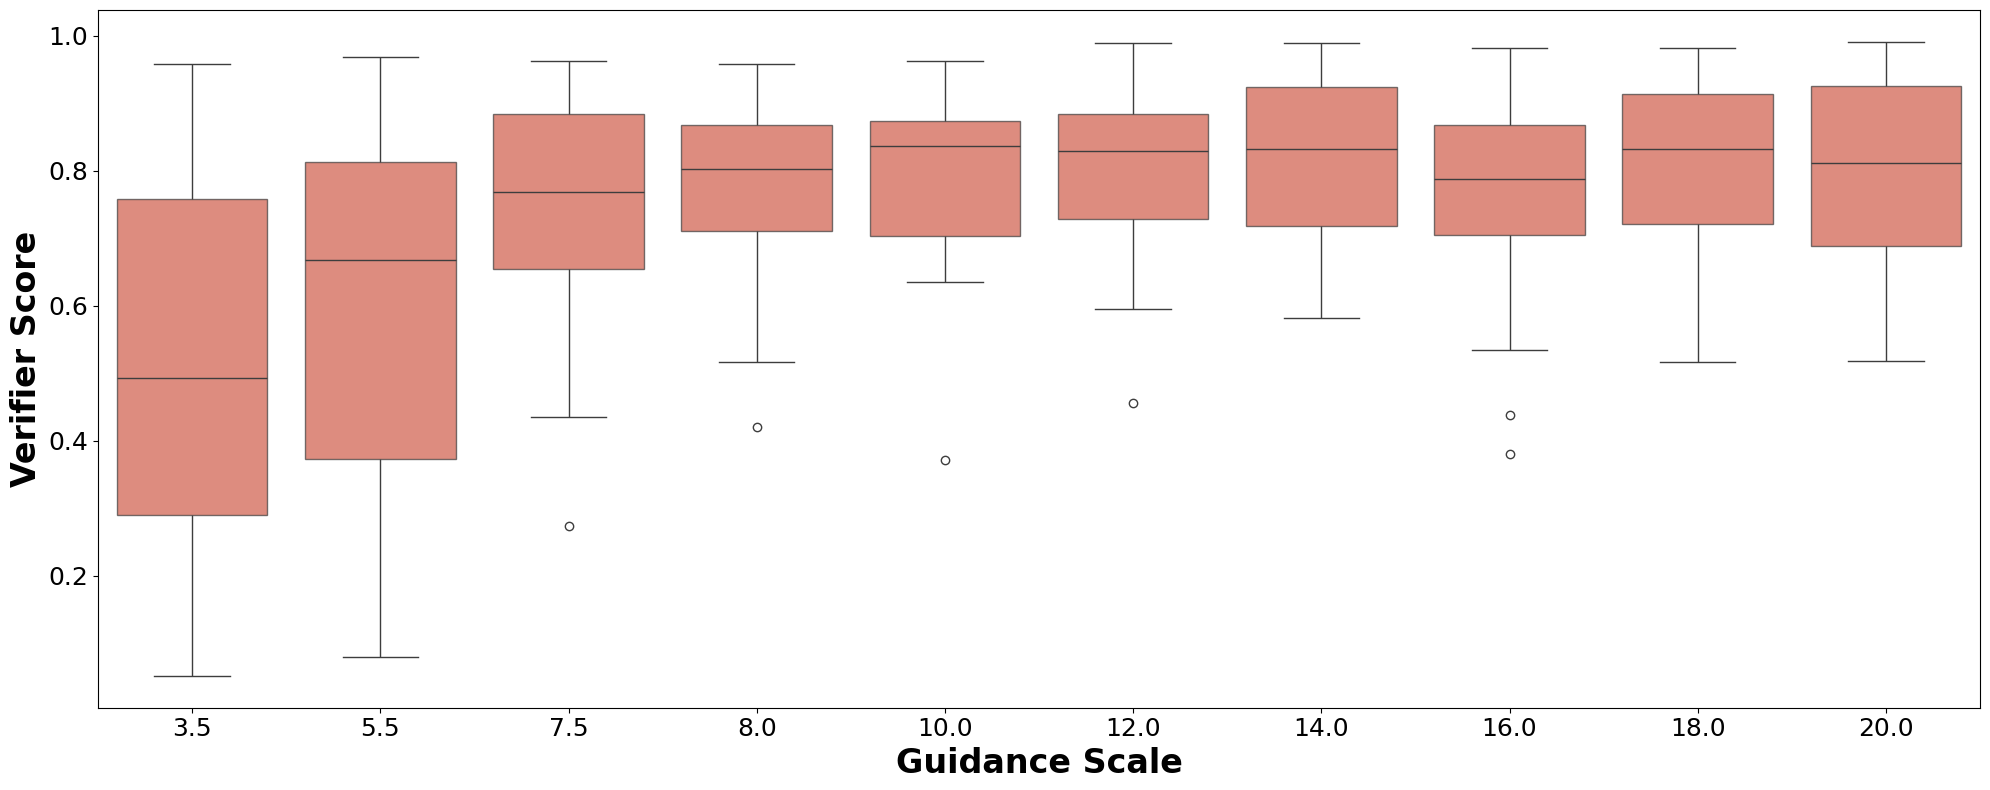

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
color = (0.9, 0.3, 0.2)
bxplt = sns.boxplot(data=[
    #t0_averages,
    #t0_noint_averages,
    #t1_averages,
    #t1_noint_averages,
    #t2_averages,
    #t2_noint_averages,
    #oracle_scores_avgs,
    #oracle_scores_noint_avgs,

    rebeca_scores[(80,3.5)],
    #rebeca_scores_noint[(80,3.5)],
    rebeca_scores[(80,5.5)],
    #rebeca_scores_noint[(80,5.5)],
    rebeca_scores[(80,7.5)],
    #rebeca_scores_noint[(80,7.5)],
    rebeca_scores[(80,8.0)],
    #rebeca_scores_noint[(80,8.0)],
    rebeca_scores[(80,10.0)],
    #rebeca_scores_noint[(80,10.0)],
    rebeca_scores[(80,12.0)],
    #rebeca_scores_noint[(80,12.0)],
    rebeca_scores[(80,14.0)],
    #rebeca_scores_noint[(80,14.0)],
    rebeca_scores[(80,16.0)],
    #rebeca_scores_noint[(80,16.0)],
    rebeca_scores[(80,18.0)],
    #rebeca_scores_noint[(80,18.0)],
    rebeca_scores[(80,20.0)],
    #rebeca_scores_noint[(80,20.0)],
    
],
color=color,
boxprops=dict(alpha=0.7))

bxplt.set_xticklabels([
    #"Baseline T0",
    #"Baseline T0 (No Int)",
    #"Baseline T1",
    #"Baseline T1 (No Int)",
    #"Baseline T2",
    #"Baseline T2 (No Int)",
    "3.5",
    #"(80, 3.5), No Int",
    "5.5",
    #"(80, 5.5), No Int",
    "7.5",
    #"(80, 7.5), No Int",
    "8.0",
    #"(80, 8.0), No Int",
    "10.0",
    #"(80, 10.0), No Int",
    "12.0",
    #"(80, 12.0), No Int",
    "14.0",
    #"(80, 14.0), No Int",
    "16.0",
    #"(80, 16.0), No Int",
    "18.0",
    #"(80, 18.0), No Int",
    "20.0",
    #"(80, 20.0), No Int",
])

#for item in bxplt.get_xticklabels():
 #   item.set_rotation(45)

bxplt.set_xlabel("Guidance Scale", weight='bold')
bxplt.set_ylabel("Verifier Score", weight='bold')
bxplt.tick_params(axis='both', labelsize=18)
bxplt.yaxis.label.set_fontsize(24)
bxplt.xaxis.label.set_fontsize(24)
plt.tight_layout()
plt.show()
bxplt.figure.savefig("../figures/verifier_scores_ablation.pdf", dpi=100)

## Global Studies

### CMMD Distances

In [4]:
from eval_utils import mmd

T0_DIR = "../data/flickr/evaluation/baselines/t0_prompt/embeddings/cmmd_embeddings.pth"
T1_DIR = "../data/flickr/evaluation/baselines/t1_prompt/embeddings/cmmd_embeddings.pth"
T2_DIR = "../data/flickr/evaluation/baselines/t2_prompt/embeddings/cmmd_embeddings.pth"
REBECA_TEST_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/test"
REBECA_T1_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_high_quality_photo_NEG_bad_quality_photo,_letters_usrthres_100_v1"
REBECA_T2_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1"
GROUND_TRUTH_DIR = "../data/flickr/evaluation/ground_truth/usrthrs_100/liked/embeddings/cmmd_embeddings.pth"

TEST_CFGS = [(80, 3.5), (80, 5.5), (80, 7.5), (80, 8.0), (80, 10.0), (80, 12.0), (80,14.0), (80, 16.0), (80, 18.0), (80, 20.0)]

In [45]:
gt_embeds = torch.load(GROUND_TRUTH_DIR, weights_only=True).to(torch.float32)
t0_embeds = torch.load(T0_DIR, weights_only=True).to(torch.float32)
t1_embeds = torch.load(T1_DIR, weights_only=True).to(torch.float32)
t2_embeds = torch.load(T2_DIR, weights_only=True).to(torch.float32)

t0_mmd = mmd(gt_embeds, t0_embeds).item()
t1_mmd = mmd(gt_embeds, t1_embeds).item()
t2_mmd = mmd(gt_embeds, t2_embeds).item()

print("Baseline CMMD Distances")
print(f"T0: {t0_mmd}")
print(f"T1: {t1_mmd}")
print(f"T2: {t2_mmd}")

Baseline CMMD Distances
T0: 1.1309385299682617
T1: 0.8770227432250977
T2: 1.5649795532226562


In [46]:
rebeca_cmmd_distances = dict()
for (spu, gs) in TEST_CFGS:
    current_test_dir = f"{REBECA_TEST_DIR}/SPU_{spu}_GS_{gs}__NEG__usrthrs_100_exp"
    current_embeds = torch.load(f"{current_test_dir}/user_7/embeddings/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
    for user in os.listdir(current_test_dir)[1:]:
        user_embeds = torch.load(f"{current_test_dir}/{user}/embeddings/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
        current_embeds = torch.concat([current_embeds, user_embeds], dim=0)
    current_mmd = mmd(gt_embeds, current_embeds).item()
    rebeca_cmmd_distances[(spu, gs)] = current_mmd
    print(f"{spu}, {gs}: {current_mmd}")

80, 3.5: 0.7193088531494141
80, 5.5: 0.7036924362182617
80, 7.5: 0.6766319274902344
80, 8.0: 0.6692409515380859
80, 10.0: 0.6538629531860352
80, 12.0: 0.7283687591552734
80, 14.0: 0.762939453125
80, 16.0: 0.8119344711303711
80, 18.0: 0.8238554000854492
80, 20.0: 0.8376836776733398


In [47]:
current_embeds = torch.load(f"{REBECA_T1_DIR}/user_0/embeddings/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
for user in os.listdir(REBECA_T1_DIR)[1:]:
    user_embeds = torch.load(f"{REBECA_T1_DIR}/{user}/embeddings/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
    current_embeds = torch.concat([current_embeds, user_embeds], dim=0)
rebeca_t1_mmd = mmd(gt_embeds, current_embeds).item()
print(rebeca_t1_mmd)

0.7845163345336914


In [48]:
current_embeds = torch.load(f"{REBECA_T2_DIR}/user_0/embeddings/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
for user in os.listdir(REBECA_T2_DIR)[1:]:
    user_embeds = torch.load(f"{REBECA_T2_DIR}/{user}/embeddings/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
    current_embeds = torch.concat([current_embeds, user_embeds], dim=0)
rebeca_t2_mmd = mmd(gt_embeds, current_embeds).item()
print(rebeca_t2_mmd)

0.998377799987793


In [49]:
y_data = []
x_data = []

for (spu, gs) in TEST_CFGS:
    y_data.append(rebeca_cmmd_distances[(spu, gs)])
    x_data.append(f"{gs}")

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_13776\699556926.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_data)


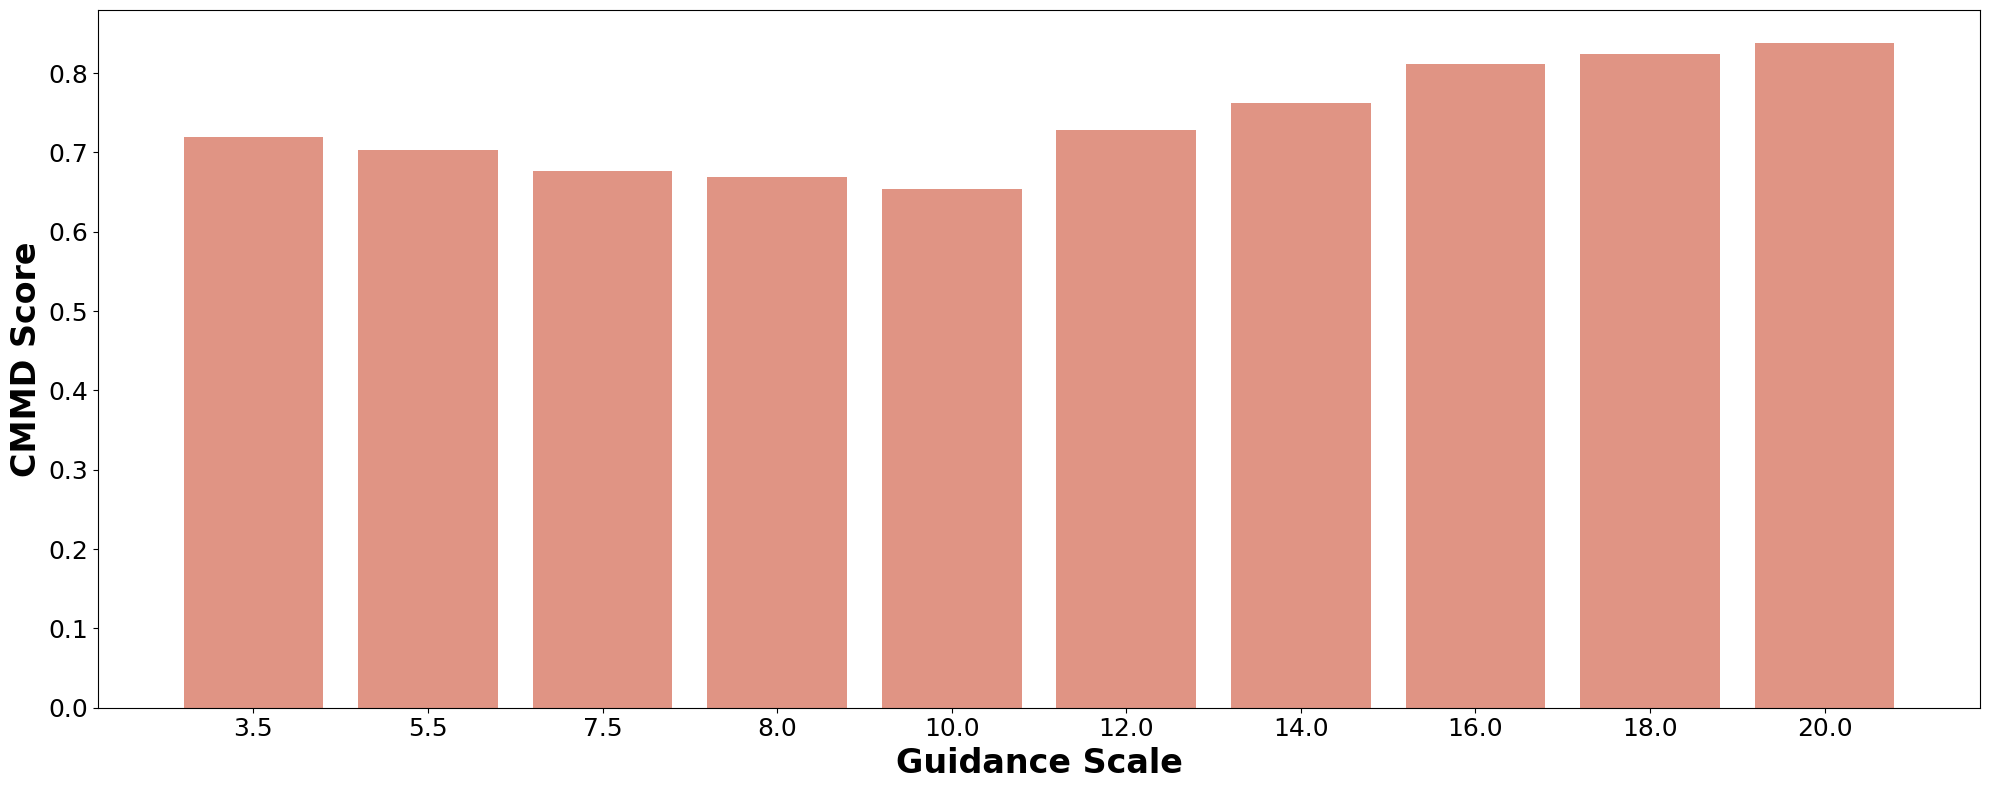

In [50]:
#plt.rc('font', weight='bold')
fig, ax = plt.subplots()
fig.set_size_inches(20.0, 8.0)
color = (0.8, 0.3, 0.2, 0.6)
ax.bar(x = x_data, height = y_data, color=color)
ax.set_xlabel("Guidance Scale", weight='bold', fontsize=24)
ax.set_xticklabels(x_data)
ax.tick_params(axis='both', labelsize=18)
ax.set_ylabel("CMMD Score", weight='bold', fontsize=24)
#plt.axhline(t0_mmd, linestyle='--')
#ax.axhline(t0_mmd, linestyle='--')
#plt.axhline(t2_mmd, linestyle='--')
plt.tight_layout()
plt.show()
fig.savefig('../figures/global_cmmd_v2.pdf', dpi=100)

### Cosine Similarity

In [16]:
csim = torch.nn.CosineSimilarity(dim=0, eps=1e-8)

def cosine_then_average(emb1, emb2):
    avg_emb_1 = torch.mean(emb1, dim=0)
    csim_list = []
    for i in range(emb2.shape[0]):
        csim_list.append(csim(avg_emb_1, emb2[i,:]))
    return np.array(csim_list).mean()

In [17]:
gt_embeds = torch.load(GROUND_TRUTH_DIR, weights_only=True).to(torch.float32)
t0_embeds = torch.load(T0_DIR, weights_only=True).to(torch.float32)
t1_embeds = torch.load(T1_DIR, weights_only=True).to(torch.float32)
t2_embeds = torch.load(T2_DIR, weights_only=True).to(torch.float32)

t0_csim = cosine_then_average(gt_embeds, t0_embeds)
t1_csim = cosine_then_average(gt_embeds, t1_embeds)
t2_csim = cosine_then_average(gt_embeds, t2_embeds)

print("Baseline Cosine Similarities")
print(f"T0: {t0_csim}")
print(f"T1: {t1_csim}")
print(f"T2: {t2_csim}")

Baseline Cosine Similarities
T0: 0.7035026550292969
T1: 0.6449164152145386
T2: 0.7172909379005432


In [45]:
GROUND_TRUTH_DIR_USER = "../data/flickr/evaluation/ground_truth/usrthrs_100/liked_per_user"
REBECA_TEST_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0__NEG__usrthres_100_v1"
T0_DIR = "../data/flickr/evaluation/baselines/t0_prompt/embeddings"

def csim_histogram_baseline(test_dir):
    csims = []
    for user_id in range(94):
        user_gt_embeds_dir = f"{GROUND_TRUTH_DIR_USER}/user_{user_id}/embeddings/cmmd_embeddings.pth"
        if not os.path.exists(user_gt_embeds_dir):
            continue
        user_gt_embeds = torch.load(user_gt_embeds_dir, weights_only=True).to(torch.float32)
        baseline_embeds_dir = f"{test_dir}/cmmd_embeddings.pth"
        baseline_embeds = torch.load(baseline_embeds_dir, weights_only=True).to(torch.float32)
        baseline_embeds_sampled_idx = np.random.choice(baseline_embeds.shape[0], 10, replace=False)
        baseline_embeds_sampled = baseline_embeds[baseline_embeds_sampled_idx]
        csim_user = cosine_then_average(user_gt_embeds, baseline_embeds)
        csims.append(csim_user)
    return csims

def csim_histogram_user(test_dir):
    csims = []
    for user_id in range(94):
        user_gt_embeds_dir = f"{GROUND_TRUTH_DIR_USER}/user_{user_id}/embeddings/cmmd_embeddings.pth"
        if not os.path.exists(user_gt_embeds_dir):
            continue
        user_gt_embeds = torch.load(user_gt_embeds_dir, weights_only=True).to(torch.float32)
        user_test_embeds_dir = f"{test_dir}/user_{user_id}/embeddings/cmmd_embeddings.pth"
        user_test_embeds = torch.load(user_test_embeds_dir, weights_only=True).to(torch.float32)
        csim_user = cosine_then_average(user_gt_embeds, user_test_embeds)
        csims.append(csim_user)
    return csims

In [42]:
baseline_embeds = torch.load(f"{T0_DIR}/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
print(baseline_embeds.shape)
baseline_embeds_sampled_idx = np.random.choice(baseline_embeds.shape[0], 10, replace=False)
baseline_embeds_sampled = baseline_embeds[baseline_embeds_sampled_idx]
print(baseline_embeds_sampled.shape)

torch.Size([5010, 768])
torch.Size([10, 768])


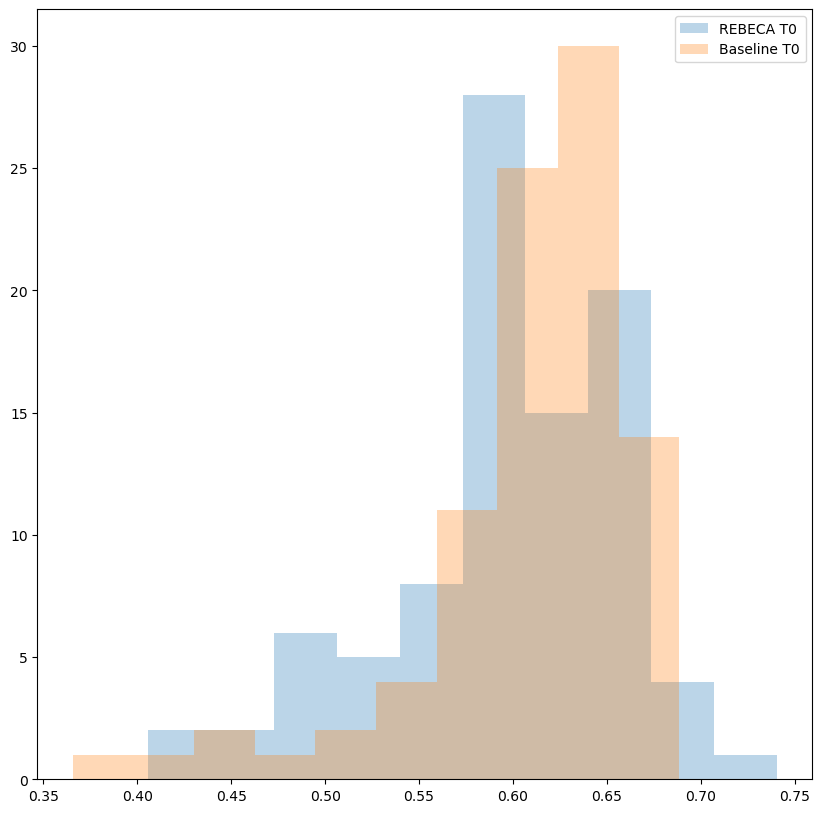

In [46]:
plt.figure(figsize=(10,10))
plt.hist(csim_histogram_user(REBECA_TEST_DIR), label='REBECA T0', alpha=0.3)
plt.hist(csim_histogram_baseline(T0_DIR), label='Baseline T0', alpha=0.3)
plt.legend()

In [127]:
rebeca_csims = dict()
for (spu, gs) in TEST_CFGS:
    current_test_dir = f"{REBECA_TEST_DIR}/SPU_{spu}_GS_{gs}__NEG__usrthrs_100_exp"
    current_embeds = torch.load(f"{current_test_dir}/user_7/embeddings/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
    for user in os.listdir(current_test_dir)[1:]:
        user_embeds = torch.load(f"{current_test_dir}/{user}/embeddings/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
        current_embeds = torch.concat([current_embeds, user_embeds], dim=0)
    current_csim = cosine_then_average(gt_embeds, current_embeds)
    rebeca_csims[(spu, gs)] = current_csim
    print(f"{spu}, {gs}: {current_csim}")

50, 3.5: 0.4623628854751587
50, 5.5: 0.46830835938453674
50, 7.5: 0.46714431047439575
80, 3.5: 0.4741755723953247
80, 5.5: 0.47886791825294495
80, 7.5: 0.48692768812179565
80, 8.0: 0.4849455952644348
80, 10.0: 0.4899516701698303
80, 12.0: 0.48611941933631897
80, 14.0: 0.49114811420440674
80, 16.0: 0.47970879077911377
80, 18.0: 0.49007970094680786
80, 20.0: 0.4831165075302124


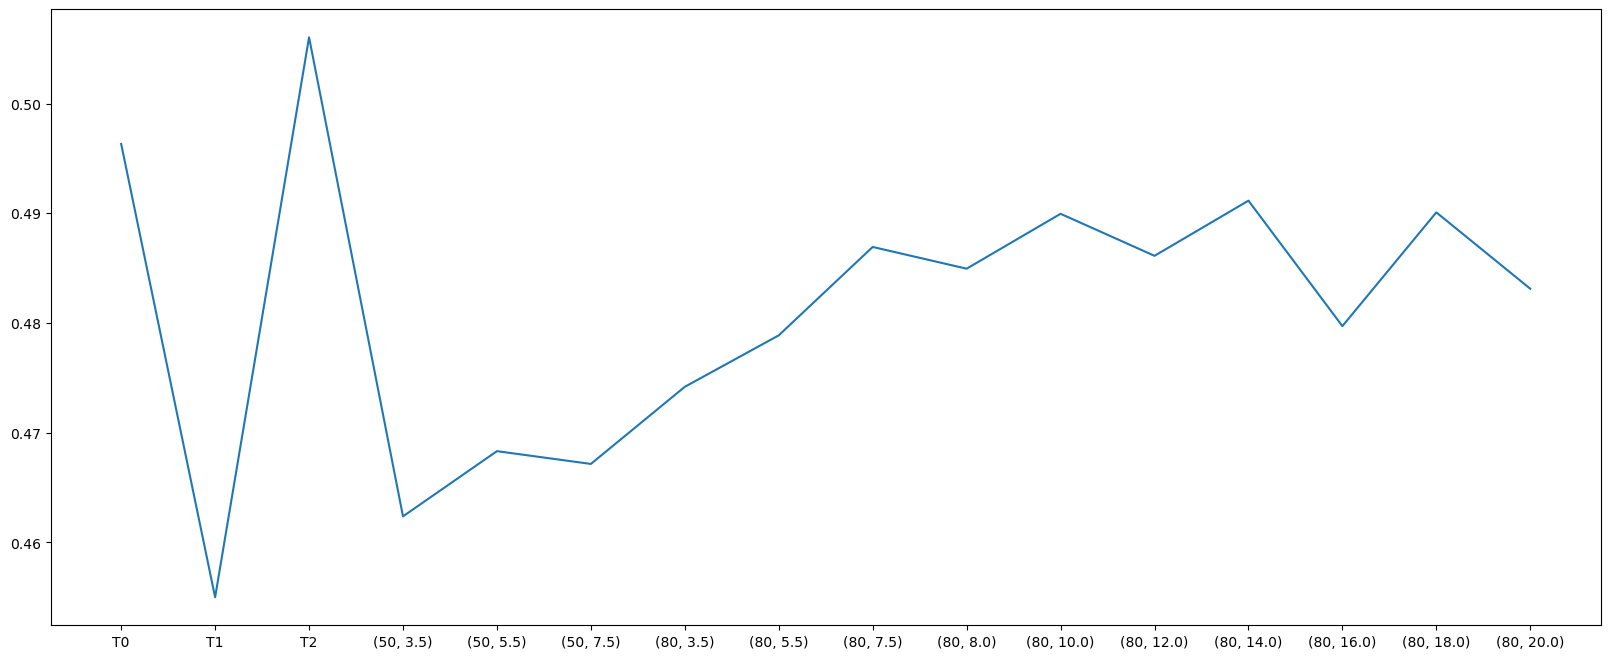

In [129]:
y_data = [t0_csim, t1_csim, t2_csim]
x_data = ["T0", "T1", "T2"]

for (spu, gs) in TEST_CFGS:
    y_data.append(rebeca_csims[(spu, gs)])
    x_data.append(f"({spu}, {gs})")

plt.figure(figsize=(20,8))
plt.plot(x_data, y_data)

### FID Scores

In [26]:
from evaluation import ModelEvaluator

T0_DIR = "../data/flickr/evaluation/baselines/t0_prompt/images"
T1_DIR = "../data/flickr/evaluation/baselines/t1_prompt/images"
T2_DIR = "../data/flickr/evaluation/baselines/t2_prompt/images"
REBECA_TEST_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/test"
#REBECA_T1_GLOBAL_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_high_quality_photo_NEG_bad_quality_photo,_letters_usrthres_100_v1_global_images"
GROUND_TRUTH_DIR = "../data/flickr/evaluation/ground_truth/usrthrs_100/liked/distshiftless/images"

TEST_CFGS = [(80, 3.5), (80, 5.5), (80, 7.5), (80, 8.0), (80, 10.0), (80, 12.0), (80,14.0), (80, 16.0), (80, 18.0), (80, 20.0)]

me = ModelEvaluator(diffusion_prior_model=None, scheduler=None)

In [29]:
me = ModelEvaluator(diffusion_prior_model=None, scheduler=None)
t0_fid = me.eval_fid(path_original=GROUND_TRUTH_DIR, path_generated=T0_DIR)
print(f"Baseline T0: {t0_fid}")

me = ModelEvaluator(diffusion_prior_model=None, scheduler=None)
t1_fid = me.eval_fid(path_original=GROUND_TRUTH_DIR, path_generated=T1_DIR)
print(f"Baseline T1: {t1_fid}")

me = ModelEvaluator(diffusion_prior_model=None, scheduler=None)
t2_fid = me.eval_fid(path_original=GROUND_TRUTH_DIR, path_generated=T2_DIR)
print(f"Baseline T2: {t2_fid}")

100%|██████████| 6/6 [00:17<00:00,  2.99s/it]


Baseline T0: 143.0008544921875


  7%|▋         | 1/15 [00:04<00:56,  4.04s/it]


KeyboardInterrupt: 

In [28]:
rebeca_fids = dict()
for (spu, gs) in TEST_CFGS:
    me = ModelEvaluator(diffusion_prior_model=None, scheduler=None)
    current_test_dir = f"{REBECA_TEST_DIR}/SPU_{spu}_GS_{gs}__NEG__usrthrs_100_exp_global_images"
    current_fid = me.eval_fid(path_original=GROUND_TRUTH_DIR, path_generated=current_test_dir)
    rebeca_fids[(spu, gs)] = current_fid
    print(f"{spu}, {gs}: {current_fid}")

100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


80, 3.5: 137.81015014648438


100%|██████████| 6/6 [00:15<00:00,  2.63s/it]


80, 5.5: 135.00704956054688


100%|██████████| 6/6 [00:14<00:00,  2.45s/it]


80, 7.5: 139.20571899414062


100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


80, 8.0: 133.88235473632812


100%|██████████| 6/6 [00:14<00:00,  2.47s/it]


80, 10.0: 135.83999633789062


100%|██████████| 6/6 [00:15<00:00,  2.60s/it]


80, 12.0: 138.63528442382812


100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


80, 14.0: 143.789306640625


100%|██████████| 6/6 [00:15<00:00,  2.61s/it]


80, 16.0: 141.28567504882812


100%|██████████| 6/6 [00:14<00:00,  2.43s/it]


80, 18.0: 148.85342407226562


100%|██████████| 6/6 [00:15<00:00,  2.50s/it]


80, 20.0: 144.45474243164062


In [52]:
final_fid_scores = np.load('final_fid_scores.npy', allow_pickle=True).item()
print(final_fid_scores)

{'T0': 121.50457763671875, 'T1': 111.72216796875, 'T2': 110.71466064453125, (50, 3.5): 110.26742553710938, (50, 5.5): 110.027587890625, (50, 7.5): 109.90310668945312, (80, 3.5): 109.44027709960938, (80, 5.5): 109.09664916992188, (80, 7.5): 108.7816162109375, (80, 8.0): 108.58090209960938, (80, 10.0): 108.38180541992188, (80, 12.0): 108.24673461914062, (80, 14.0): 108.1728515625, (80, 16.0): 108.09921264648438, (80, 18.0): 108.13787841796875, (80, 20.0): 108.10372924804688}


In [53]:
x_data = []
y_data = []
for k,v in final_fid_scores.items():
    if k == "T0" or k == "T1" or k == "T2":
        continue
    else:
        (spu, gs) = k
        if spu == 50:
            continue
        x_data.append(f"{gs}")
        y_data.append(final_fid_scores[k])
        print(f"Processed SPU {spu} GS {gs}")

Processed SPU 80 GS 3.5
Processed SPU 80 GS 5.5
Processed SPU 80 GS 7.5
Processed SPU 80 GS 8.0
Processed SPU 80 GS 10.0
Processed SPU 80 GS 12.0
Processed SPU 80 GS 14.0
Processed SPU 80 GS 16.0
Processed SPU 80 GS 18.0
Processed SPU 80 GS 20.0


C:\Users\Gabriel\AppData\Local\Temp\ipykernel_13776\4246243128.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_data)


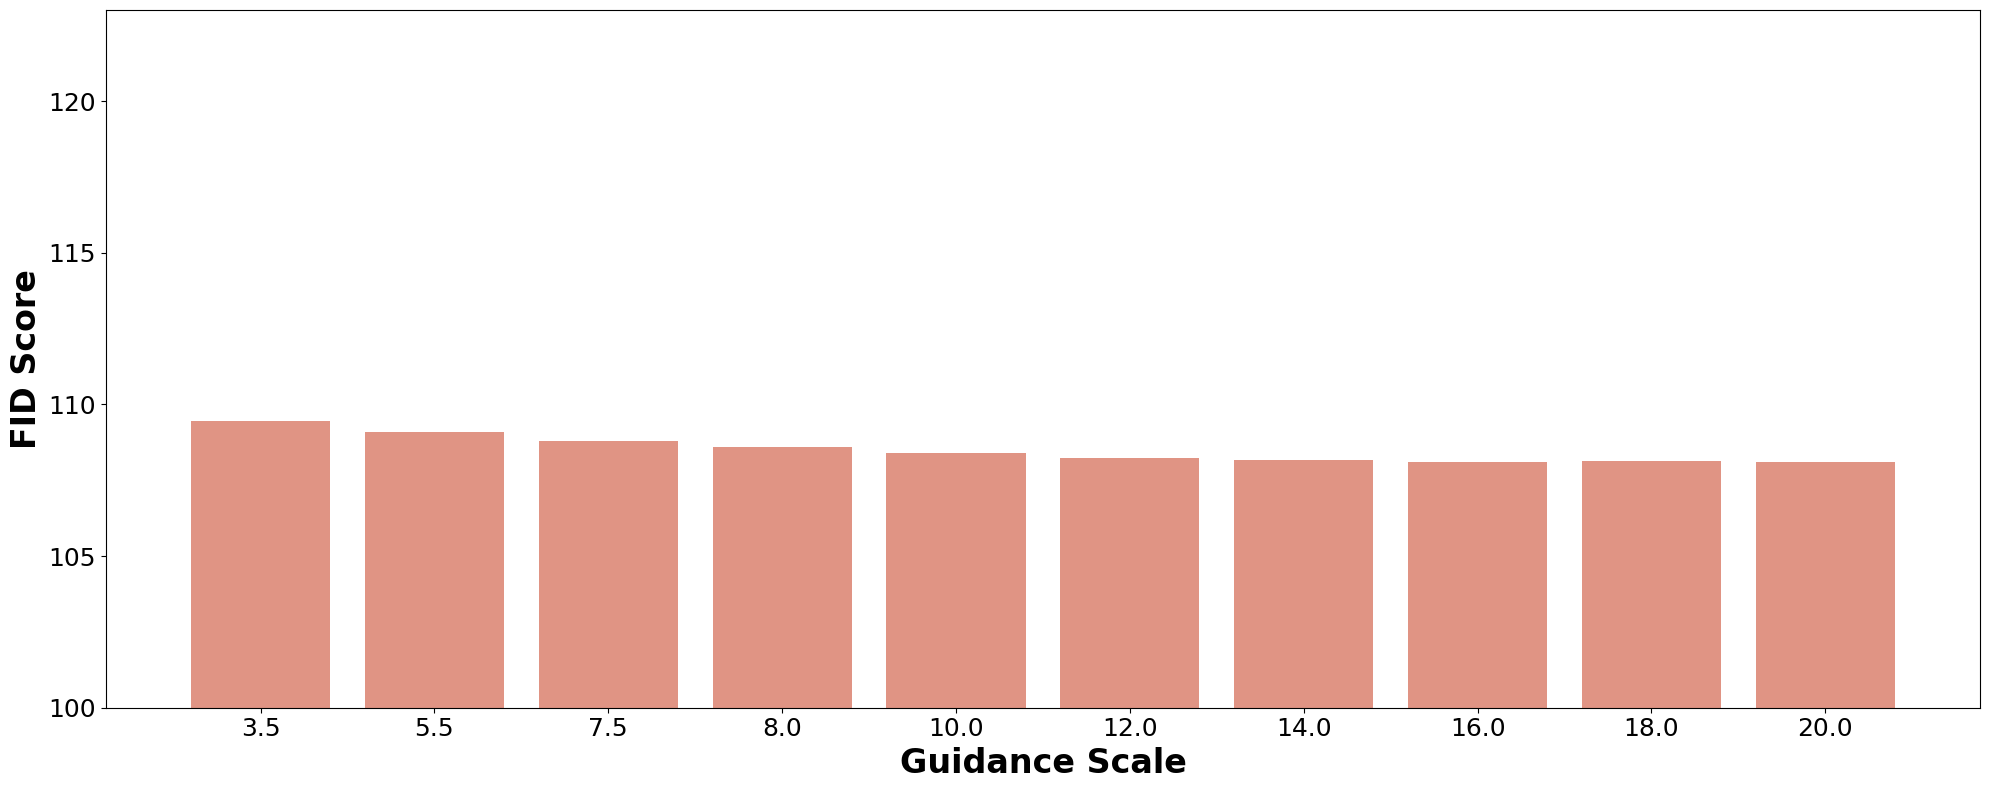

In [54]:
#plt.rc('font', weight='bold')
fig, ax = plt.subplots()
fig.set_size_inches(20.0, 8.0)
color = (0.8, 0.3, 0.2, 0.6)
ax.bar(x = x_data, height = y_data, color=color)
ax.set_ylim(ymin=100, ymax=123)
ax.set_xlabel("Guidance Scale", weight='bold', fontsize=24)
ax.set_xticklabels(x_data)
ax.tick_params(axis='both', labelsize=18)
ax.set_ylabel("FID Score", weight='bold', fontsize=24)
#plt.axhline(t0_mmd, linestyle='--')
#ax.axhline(final_fid_scores["T2"], linestyle='--')
#plt.axhline(t2_mmd, linestyle='--')
plt.tight_layout()
plt.show()
fig.savefig('../figures/global_fid_v2.pdf', dpi=100)

## User-by-User Studies

In [2]:
from evaluation import ModelEvaluator

T0_DIR = "../data/flickr/evaluation/baselines/t0_prompt/embeddings/cmmd_embeddings.pth"
T1_DIR = "../data/flickr/evaluation/baselines/t1_prompt/embeddings/cmmd_embeddings.pth"
T2_DIR = "../data/flickr/evaluation/baselines/t2_prompt/embeddings/cmmd_embeddings.pth"
REBECA_TEST_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/test"
GROUND_TRUTH_DIR = "../data/flickr/evaluation/ground_truth/usrthrs_100/liked_per_user"

TEST_CFGS = [(50, 3.5), (50, 5.5), (50, 7.5), (80, 3.5), (80, 5.5), (80, 7.5), (80, 8.0), (80, 10.0), (80, 12.0), (80,14.0), (80, 16.0), (80, 18.0), (80, 20.0)]

me = ModelEvaluator(diffusion_prior_model=None, scheduler=None)

In [3]:
GT_USERS = []
for upath in os.listdir(GROUND_TRUTH_DIR):
    user = int(upath.split("_")[1])
    count_images = len(os.listdir(f"{GROUND_TRUTH_DIR}/{upath}/images"))
    if count_images >= 2:
        GT_USERS.append(user)

TEST_USERS = []
for upath in os.listdir(f"{REBECA_TEST_DIR}/SPU_50_GS_3.5__NEG__usrthrs_100_exp"):
    user = int(upath.split("_")[1])
    TEST_USERS.append(user)

SELECTED_USERS = list(set(TEST_USERS) & set(GT_USERS))
len(SELECTED_USERS)

28

### CMMD

In [6]:
from eval_utils import mmd

rebeca_cmmds = dict()

for (spu, gs) in TEST_CFGS:
    print(spu, gs)
    current_rebeca_cmmds = []
    for user in SELECTED_USERS:
        gt_user_embeds = torch.load(f"{GROUND_TRUTH_DIR}/user_{user}/embeddings/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
        rebeca_current_dir = f"{REBECA_TEST_DIR}/SPU_{spu}_GS_{gs}__NEG__usrthrs_100_exp/user_{user}/embeddings/cmmd_embeddings.pth"
        rebeca_embeds = torch.load(rebeca_current_dir, weights_only=True).to(torch.float32)

        rebeca_current_mmd = mmd(gt_user_embeds, rebeca_embeds).item()
        current_rebeca_cmmds.append(rebeca_current_mmd)
    rebeca_cmmds[(spu, gs)] = current_rebeca_cmmds
    print(rebeca_cmmds[(spu, gs)])

50 3.5
[3.7031173706054688, 4.821419715881348, 3.142118453979492, 3.2743215560913086, 2.6324987411499023, 3.4029483795166016, 3.352642059326172, 3.838658332824707, 4.0024518966674805, 5.853533744812012, 3.7584304809570312, 4.035711288452148, 2.184152603149414, 3.3638477325439453, 2.328634262084961, 3.375887870788574, 2.8089284896850586, 2.949357032775879, 5.572199821472168, 4.788875579833984, 4.146099090576172, 4.069089889526367, 4.4220685958862305, 2.498626708984375, 3.5163164138793945, 4.562020301818848, 3.6209821701049805, 2.6754140853881836]
50 5.5
[3.0934810638427734, 6.377935409545898, 4.496216773986816, 3.7615299224853516, 2.6662349700927734, 3.3800601959228516, 4.839301109313965, 3.11434268951416, 4.23431396484375, 5.402088165283203, 3.21352481842041, 4.499554634094238, 2.2535324096679688, 3.1824111938476562, 1.9135475158691406, 3.4848451614379883, 2.9217004776000977, 4.23431396484375, 4.978537559509277, 4.637479782104492, 3.3403635025024414, 3.3451318740844727, 5.9571266174316

In [7]:
from eval_utils import mmd

t0_cmmds = []
t1_cmmds = []
t2_cmmds = []

t0_user_embeds = torch.load(T0_DIR, weights_only=True).to(torch.float32)
t1_user_embeds = torch.load(T1_DIR, weights_only=True).to(torch.float32)
t2_user_embeds = torch.load(T2_DIR, weights_only=True).to(torch.float32)

for user in SELECTED_USERS:
    gt_user_embeds = torch.load(f"{GROUND_TRUTH_DIR}/user_{user}/embeddings/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
    idx = np.random.randint(5000, size=12)
    sampled_t0_embeds = t0_user_embeds[idx, :]
    sampled_t1_embeds = t1_user_embeds[idx, :]
    sampled_t2_embeds = t2_user_embeds[idx, :]

    t0_mmd_user = mmd(gt_user_embeds, sampled_t0_embeds).item()
    t1_mmd_user = mmd(gt_user_embeds, sampled_t1_embeds).item()
    t2_mmd_user = mmd(gt_user_embeds, sampled_t2_embeds).item()

    t0_cmmds.append(t0_mmd_user)
    t1_cmmds.append(t1_mmd_user)
    t2_cmmds.append(t2_mmd_user)

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_7088\305910251.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bxplt.set_xticklabels(xlabels)


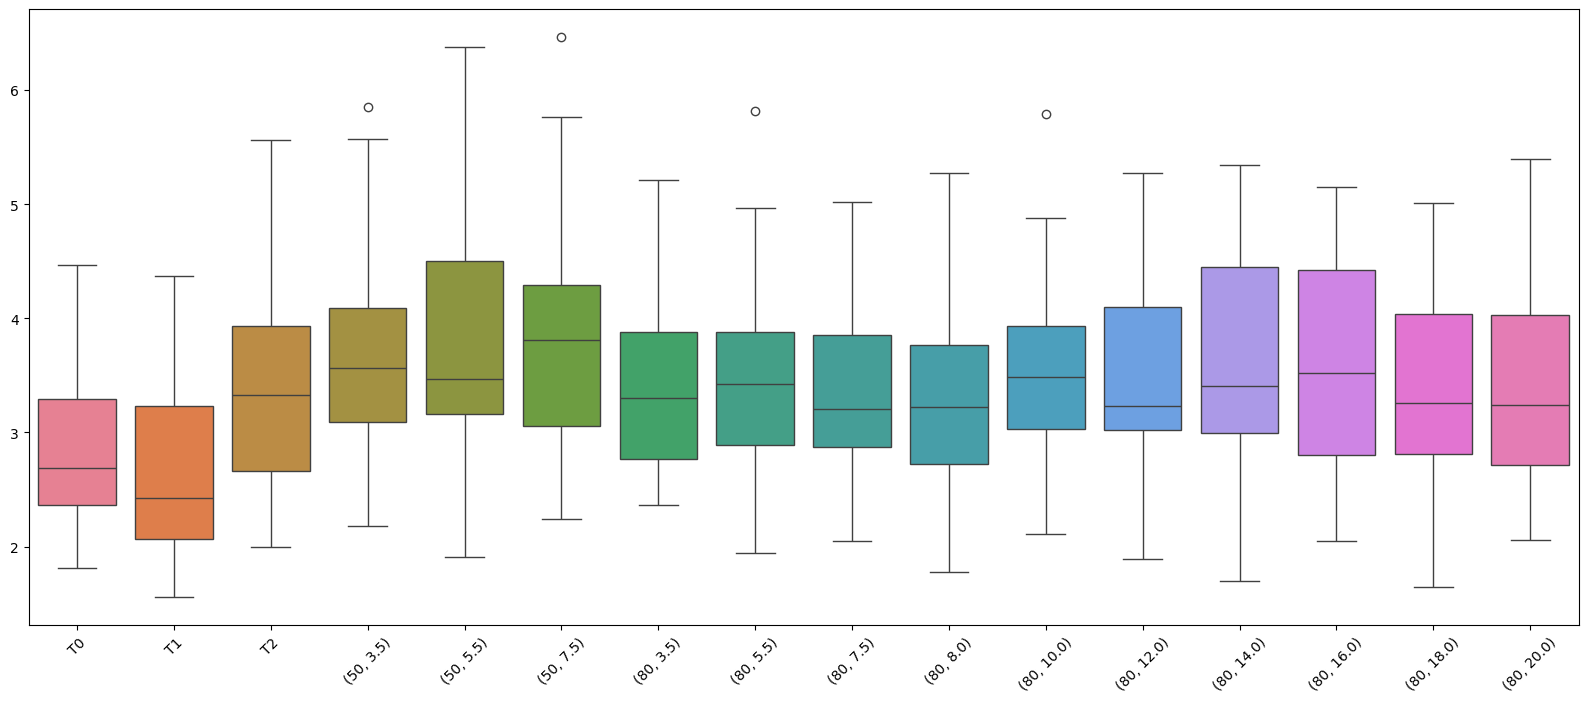

In [10]:
data = [t0_cmmds, t1_cmmds, t2_cmmds]
xlabels = ["T0", "T1", "T2"]
for (spu, gs) in TEST_CFGS:
    data.append(rebeca_cmmds[(spu, gs)])
    xlabels.append(f"({spu}, {gs})")

plt.figure(figsize=(20,8))
bxplt = sns.boxplot(data=data)
bxplt.set_xticklabels(xlabels)
for item in bxplt.get_xticklabels():
    item.set_rotation(45)

## Custom Prior Sanity Checks

In [11]:
import sys
sys.path.append('../')

from sampling import sample_from_diffusion
from prior_models import TransformerEmbeddingDiffusionModelv2
from diffusers import DDPMScheduler
from eval_utils import evaluate_user_prior_full
import torch
import pandas as pd

device = "cuda"

In [76]:
t0_dir = "../data/flickr/evaluation/baselines/t0_prompt/embeddings/sd15_embeddings.pt"
t0_embeds = torch.load(t0_dir, weights_only=True).to(torch.float32).numpy()

t1_dir = "../data/flickr/evaluation/baselines/t1_prompt/embeddings/sd15_embeddings.pt"
t1_embeds = torch.load(t0_dir, weights_only=True).to(torch.float32).numpy()

t2_dir = "../data/flickr/evaluation/baselines/t2_prompt/embeddings/sd15_embeddings.pt"
t2_embeds = torch.load(t0_dir, weights_only=True).to(torch.float32).numpy()

In [9]:
train_ie_dir = "../data/flickr/processed/train/train_ie_usrthrs_100.pth"
train_ie = torch.load(train_ie_dir, weights_only=True).to(torch.float32).numpy()
train_df = pd.read_csv("../data/flickr/processed/train_usrthrs_100.csv")


val_ie_dir = "../data/flickr/processed/train/validation_ie_usrthrs_100.pth"
val_ie = torch.load(val_ie_dir, weights_only=True).to(torch.float32).numpy()
val_df = pd.read_csv("../data/flickr/processed/validation_usrthrs_100.csv")

test_ie_dir = "../data/flickr/processed/test/test_ie_usrthrs_100.pth"
test_ie = torch.load(test_ie_dir, weights_only=True).to(torch.float32).numpy()
test_df = pd.read_csv("../data/flickr/processed/test_usrthrs_100.csv")

In [34]:
noise_scheduler = DDPMScheduler(6000)
diffusion_prior_model = TransformerEmbeddingDiffusionModelv2(
    img_embed_dim=1024,
    num_users=94,    # So user embedding covers your entire user set
    n_heads=16,
    num_tokens=1,
    num_user_tokens=4,
    num_layers=8,
    dim_feedforward=2048,
    whether_use_user_embeddings=True
).to(device)

savepath = f"../data/flickr/evaluation/diffusion_priors/models/weights/sd15_nl8_heads16_dim_feedforward2048_lr0.0001_it1_ut4_adamw_reduce_on_plateau_bs64_nslinear_spu80_timesteps6000_objnoise-pred_useueTrue.pth"
diffusion_prior_model.load_state_dict(torch.load(savepath, map_location="cuda"), strict=False)


c:\Users\Gabriel\anaconda3\envs\recgensys-env\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [70]:
CFG = 10.0
user_id = 7
embeddings_per_user = 40
score_tensor = torch.tensor(1).expand(embeddings_per_user).long().to(device)
user_tensor = torch.tensor(user_id).expand(embeddings_per_user).to(device)
user_ids_uncond_tensor = torch.full_like(user_tensor, fill_value = 94).to(device)
score_uncond_tensor = torch.full_like(score_tensor, fill_value = 2).to(device)



user_prior_ie = sample_from_diffusion(
    model=diffusion_prior_model,
    user_ids_cond=user_tensor,
    scores_cond=score_tensor,
    user_ids_uncond=user_ids_uncond_tensor,
    scores_uncond=score_uncond_tensor,
    img_embedding_size=1024,
    scheduler=noise_scheduler,
    guidance_scale=CFG,
    prediction_type="epsilon",
    device="cuda",
).cpu().numpy()

In [71]:
CFG = 10.0
uncond_user_id = 94
embeddings_per_user = 30
score_tensor = torch.tensor(1).expand(embeddings_per_user).long().to(device)
user_tensor = torch.tensor(uncond_user_id).expand(embeddings_per_user).to(device)
user_ids_uncond_tensor = torch.full_like(user_tensor, fill_value = 94).to(device)
score_uncond_tensor = torch.full_like(score_tensor, fill_value = 2).to(device)



user_prior_ie_uncond_U = sample_from_diffusion(
    model=diffusion_prior_model,
    user_ids_cond=user_tensor,
    scores_cond=score_tensor,
    user_ids_uncond=user_ids_uncond_tensor,
    scores_uncond=score_uncond_tensor,
    img_embedding_size=1024,
    scheduler=noise_scheduler,
    guidance_scale=CFG,
    prediction_type="epsilon",
    device="cuda",
).cpu().numpy()

score_tensor = torch.tensor(2).expand(embeddings_per_user).long().to(device)

user_prior_ie_uncond_L = sample_from_diffusion(
    model=diffusion_prior_model,
    user_ids_cond=user_tensor,
    scores_cond=score_tensor,
    user_ids_uncond=user_ids_uncond_tensor,
    scores_uncond=score_uncond_tensor,
    img_embedding_size=1024,
    scheduler=noise_scheduler,
    guidance_scale=CFG,
    prediction_type="epsilon",
    device="cuda",
).cpu().numpy()


user_prior_ie_uncond_UL = sample_from_diffusion(
    model=diffusion_prior_model,
    user_ids_cond=user_tensor,
    scores_cond=score_tensor,
    user_ids_uncond=user_ids_uncond_tensor,
    scores_uncond=score_uncond_tensor,
    img_embedding_size=1024,
    scheduler=noise_scheduler,
    guidance_scale=CFG,
    prediction_type="epsilon",
    device="cuda",
).cpu().numpy()

In [28]:
evaluate_user_prior_full(
    user_id=7,
    train_df=train_df,
    train_ie=train_ie,
    val_df=val_df,
    val_ie=val_ie,
    test_df=test_df,
    test_ie=test_ie,
    user_prior_ie=user_prior_ie,      # Original Prior
    unconditional_ie=user_prior_ie_uncond_UL,
    baseline_t0=t0_embeds,    
    like_threshold=4,  
    use_train=False,  
    baseline_label="Baseline",
    prior_label="DiffusionPrior",
    unconditional_label="Uncond",
    dimred_method="pca",  # Change to "tsne" if you want t-SNE visualization
    tsne_perplexity=40.0,
)

NameError: name 'evaluate_user_prior_full' is not defined

## Inception Scores Scratch

In [17]:
from torchmetrics.image.inception import InceptionScore
import torchvision

In [18]:
inception_t0 = InceptionScore()

T0_PATH = "../data/flickr/evaluation/baselines/t0_prompt/images"
images_tensor = torchvision.io.read_image(f"{T0_PATH}/image_0.png").unsqueeze(dim=0)
for i in range(1,100):
    current_image = torchvision.io.read_image(f"{T0_PATH}/image_{i}.png").unsqueeze(dim=0)
    images_tensor = torch.cat((images_tensor, current_image), dim=0)
inception_t0.update(images_tensor)
inception_t0.compute()

c:\Users\Gabriel\anaconda3\envs\recgensys-env\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


(tensor(4.9203), tensor(0.6309))

In [19]:
inception_t1 = InceptionScore()

T1_PATH = "../data/flickr/evaluation/baselines/t1_prompt/images"
images_tensor = torchvision.io.read_image(f"{T1_PATH}/image_0.png").unsqueeze(dim=0)
for i in range(1,100):
    current_image = torchvision.io.read_image(f"{T1_PATH}/image_{i}.png").unsqueeze(dim=0)
    images_tensor = torch.cat((images_tensor, current_image), dim=0)
inception_t1.update(images_tensor)
inception_t1.compute()

c:\Users\Gabriel\anaconda3\envs\recgensys-env\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


(tensor(4.2510), tensor(0.3638))

In [20]:
inception_t2 = InceptionScore()

T2_PATH = "../data/flickr/evaluation/baselines/t2_prompt/images"
images_tensor = torchvision.io.read_image(f"{T2_PATH}/image_0.png").unsqueeze(dim=0)
for i in range(1,100):
    current_image = torchvision.io.read_image(f"{T2_PATH}/image_{i}.png").unsqueeze(dim=0)
    images_tensor = torch.cat((images_tensor, current_image), dim=0)
inception_t2.update(images_tensor)
inception_t2.compute()

c:\Users\Gabriel\anaconda3\envs\recgensys-env\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


(tensor(4.1728), tensor(0.5602))

In [27]:
test_dir = "../data/flickr/evaluation/diffusion_priors/models/samples/test/SPU_80_GS_10.0__NEG__usrthrs_100_exp_global_images"
inception_test = InceptionScore()
first_path = os.listdir(test_dir)[0]
images_tensor = torchvision.io.read_image(f"{test_dir}/{first_path}").unsqueeze(dim=0)
for i, upath in enumerate(os.listdir(test_dir)):
    if i == 0:
        continue
    if i > 100:
        break
    current_image = torchvision.io.read_image(f"{test_dir}/{first_path}").unsqueeze(dim=0)
    images_tensor = torch.cat((images_tensor, current_image), dim=0)
inception_test.update(images_tensor)
inception_test.compute()

c:\Users\Gabriel\anaconda3\envs\recgensys-env\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


(tensor(1.), tensor(1.1239e-07))

## Ablation Studies

In [72]:
from eval_utils import mmd

REBECA_T0_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0__NEG__usrthres_100_v1"
REBECA_NOUE_T0_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0__NEG__NoUE_usrthres_100"
REBECA_T1_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_high_quality_photo_NEG_bad_quality_photo,_letters_usrthres_100_v1"
REBECA_T2_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1"
GROUND_TRUTH_DIR = "../data/flickr/evaluation/ground_truth/usrthrs_100/liked/embeddings/cmmd_embeddings.pth"

In [73]:
#current_embeds = torch.load(f"{REBECA_T0_DIR}/user_0/embeddings/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
for i, user in enumerate(os.listdir(REBECA_T0_DIR)):
    if i == 0:
        current_embeds = torch.load(f"{REBECA_T0_DIR}/{user}/embeddings/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
        continue
    user_embeds = torch.load(f"{REBECA_T0_DIR}/{user}/embeddings/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
    current_embeds = torch.concat([current_embeds, user_embeds], dim=0)
rebeca_t0_mmd = mmd(gt_embeds, current_embeds).item()
print(f"REBECA T0: {rebeca_t0_mmd}")

REBECA T0: 0.6773471832275391


In [74]:
#current_embeds = torch.load(f"{REBECA_T0_DIR}/user_0/embeddings/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
for i, user in enumerate(os.listdir(REBECA_T1_DIR)):
    if i == 0:
        current_embeds = torch.load(f"{REBECA_T1_DIR}/{user}/embeddings/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
        continue
    user_embeds = torch.load(f"{REBECA_T1_DIR}/{user}/embeddings/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
    current_embeds = torch.concat([current_embeds, user_embeds], dim=0)
rebeca_t1_mmd = mmd(gt_embeds, current_embeds).item()
print(f"REBECA T1: {rebeca_t1_mmd}")

REBECA T1: 0.7845163345336914


In [75]:
#current_embeds = torch.load(f"{REBECA_T0_DIR}/user_0/embeddings/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
for i, user in enumerate(os.listdir(REBECA_T0_NOUE_DIR)):
    if i == 0:
        current_embeds = torch.load(f"{REBECA_T0_NOUE_DIR}/{user}/embeddings/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
        continue
    user_embeds = torch.load(f"{REBECA_T0_NOUE_DIR}/{user}/embeddings/cmmd_embeddings.pth", weights_only=True).to(torch.float32)
    current_embeds = torch.concat([current_embeds, user_embeds], dim=0)
rebeca_t0_noue_mmd = mmd(gt_embeds, current_embeds).item()
print(f"REBECA T0 No UE: {rebeca_t0_noue_mmd}")

REBECA T0 No UE: 1.201629638671875


In [7]:
from evaluation import ModelEvaluator

REBECA_T0_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0__NEG__usrthres_100_v1_global_images"
REBECA_NOUE_T0_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0__NEG__NoUE_usrthres_100_global_images"
REBECA_T1_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_high_quality_photo_NEG_bad_quality_photo,_letters_usrthres_100_v1_global_images"
GROUND_TRUTH_DIR = "../data/flickr/evaluation/ground_truth/usrthrs_100/liked/images"
REBECA_T2_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0_Realistic_image,_finely_detail_NEG_deformed,_ugly,_wrong_proporti_usrthres_100_v1_global_images"

REBECA_T0__user0_DIR = "../data/flickr/evaluation/diffusion_priors/models/samples/final/SPU_80_GS_10.0__NEG__usrthres_100_v1/user_0/images"


In [100]:
me = ModelEvaluator(diffusion_prior_model=None, scheduler=None)
t0_fid = me.eval_fid(path_original=GROUND_TRUTH_DIR, path_generated=REBECA_T0_DIR)
print(f"T0: {t0_fid}")

100%|██████████| 75/75 [03:37<00:00,  2.90s/it]


T0: 117.7742919921875


In [101]:
me = ModelEvaluator(diffusion_prior_model=None, scheduler=None)
t1_fid = me.eval_fid(path_original=GROUND_TRUTH_DIR, path_generated=REBECA_T1_DIR)
print(f"T1: {t1_fid}")

100%|██████████| 45/45 [02:11<00:00,  2.92s/it]


T1: 124.21600341796875


In [8]:
me = ModelEvaluator(diffusion_prior_model=None, scheduler=None)
t2_fid = me.eval_fid(path_original=GROUND_TRUTH_DIR, path_generated=REBECA_T2_DIR)
print(f"T2: {t2_fid}")

100%|██████████| 30/30 [01:26<00:00,  2.89s/it]


T2: 130.55712890625


In [102]:
me = ModelEvaluator(diffusion_prior_model=None, scheduler=None)
t0_noue_fid = me.eval_fid(path_original=GROUND_TRUTH_DIR, path_generated=REBECA_NOUE_T0_DIR)
print(f"T0 No UE: {t0_noue_fid}")

100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


T0 No UE: 172.29055786132812


In [110]:
len(os.listdir(REBECA_NOUE_T0_DIR)), len(os.listdir(GROUND_TRUTH_DIR))

(300, 351)